# Sparse Autoencoder Visualization

This notebook is to learn and visualize the features learned by different sparse autoencoders, in order to understand the patterns of the learned model.

## LLM Implementation

Epoch [1/50], Loss: 36.7810
Epoch [2/50], Loss: 20.5271
Epoch [3/50], Loss: 16.0501
Epoch [4/50], Loss: 12.7314
Epoch [5/50], Loss: 10.6214
Epoch [6/50], Loss: 9.1791
Epoch [7/50], Loss: 8.1033
Epoch [8/50], Loss: 7.2728
Epoch [9/50], Loss: 6.5880
Epoch [10/50], Loss: 6.0238
Epoch [11/50], Loss: 5.5803
Epoch [12/50], Loss: 5.1716
Epoch [13/50], Loss: 4.8358
Epoch [14/50], Loss: 4.5637
Epoch [15/50], Loss: 4.3056
Epoch [16/50], Loss: 4.1009
Epoch [17/50], Loss: 3.8963
Epoch [18/50], Loss: 3.7169
Epoch [19/50], Loss: 3.5694
Epoch [20/50], Loss: 3.4276
Epoch [21/50], Loss: 3.3013
Epoch [22/50], Loss: 3.1889
Epoch [23/50], Loss: 3.0836
Epoch [24/50], Loss: 2.9918
Epoch [25/50], Loss: 2.9013
Epoch [26/50], Loss: 2.8156
Epoch [27/50], Loss: 2.7290
Epoch [28/50], Loss: 2.6677
Epoch [29/50], Loss: 2.5955
Epoch [30/50], Loss: 2.5344
Epoch [31/50], Loss: 2.4762
Epoch [32/50], Loss: 2.4192
Epoch [33/50], Loss: 2.3636
Epoch [34/50], Loss: 2.3185
Epoch [35/50], Loss: 2.2679
Epoch [36/50], Loss: 2.2

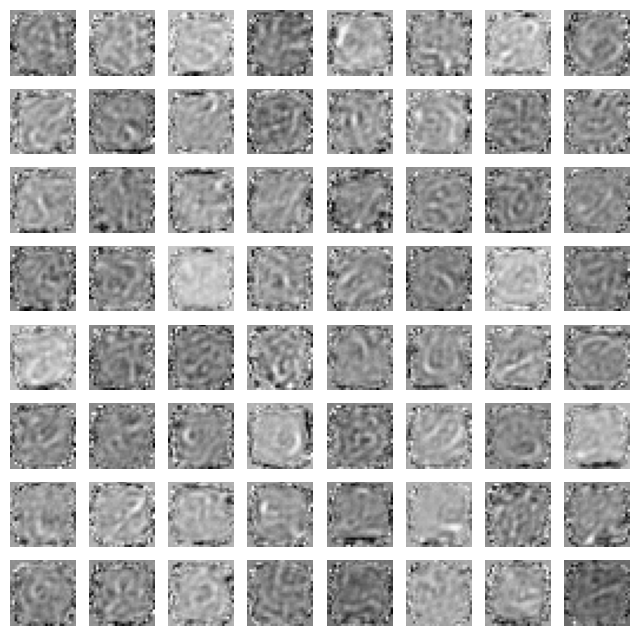

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, sparsity_param=0.1, lambda_sparse=3.0, alpha_aux=1.0):
        """
        Initializes the Sparse Autoencoder.

        Args:
            input_size (int): Dimension of the input data (d in the formula).
            hidden_size (int): Number of neurons in the hidden layer.
            sparsity_param (float): The target sparsity level (rho).
            lambda_sparse (float): The weight for the sparsity loss (lambda).
            alpha_aux (float): The weight for the auxiliary loss (alpha).
        """
        super(SparseAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity_param = sparsity_param
        self.lambda_sparse = lambda_sparse
        self.alpha_aux = alpha_aux

        # Encoder maps input to hidden representation
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )

        # Decoder maps hidden representation back to input space
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Use Sigmoid if input data is normalized between 0 and 1
        )

    def forward(self, x):
        """
        Performs a forward pass through the autoencoder.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            tuple: A tuple containing:
                - h (torch.Tensor): The hidden layer activations.
                - x_hat (torch.Tensor): The reconstructed output.
        """
        h = self.encoder(x)
        x_hat = self.decoder(h)
        return h, x_hat

    def kl_divergence(self, rho_hat):
        """Calculates the KL divergence for the sparsity penalty."""
        rho = torch.tensor(self.sparsity_param).to(rho_hat.device)
        # Add a small epsilon for numerical stability
        rho_hat = torch.clamp(rho_hat, 1e-10, 1 - 1e-10)

        term1 = rho * torch.log(rho / rho_hat)
        term2 = (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))

        return torch.sum(term1 + term2)

    def auxiliary_loss(self, x, x_hat):
        """
        An example auxiliary loss. Here, we use Mean Absolute Error (L1 Loss).
        You can replace this with any other loss function.
        """
        return torch.mean(torch.abs(x - x_hat))

    def compute_loss(self, x, h, x_hat):
        """
        Computes the total loss based on the provided formula.

        Args:
            x (torch.Tensor): The original input.
            h (torch.Tensor): The hidden layer activations.
            x_hat (torch.Tensor): The reconstructed output.

        Returns:
            tuple: A tuple containing:
                - total_loss (torch.Tensor): The combined loss.
                - recon_loss (torch.Tensor): The reconstruction loss component.
                - sparse_loss (torch.Tensor): The sparsity loss component.
                - aux_loss (torch.Tensor): The auxiliary loss component.
        """
        # 1. Reconstruction Loss: (1/d) * ||x - x_hat||^2_2
        # We compute sum of squares and normalize by input dimension 'd'
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # 2. Sparsity Loss: lambda * L_sparse(h)
        # First, calculate average activation rho_hat across the batch
        rho_hat = torch.mean(h, dim=0)
        sparse_penalty = self.kl_divergence(rho_hat)
        sparse_loss = self.lambda_sparse * sparse_penalty

        # 3. Auxiliary Loss: alpha * L_aux(x, x_hat)
        aux_penalty = self.auxiliary_loss(x, x_hat)
        aux_loss = self.alpha_aux * aux_penalty

        # Total Loss
        total_loss = recon_loss + sparse_loss + aux_loss

        return total_loss, recon_loss, sparse_loss, aux_loss


# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SparseAutoencoder(input_size=784, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        h, outputs = model(inputs)
        loss, recon_loss, sparse_loss, aux_loss = model.compute_loss(inputs, h, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')
print('Finished Training')
# Visualization of learned features
def visualize_weights(model, num_features=64):
    weights = model.encoder[0].weight.data.cpu().numpy()
    plt.figure(figsize=(8, 8))
    for i in range(num_features):
        plt.subplot(8, 8, i + 1)
        plt.imshow(weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()
visualize_weights(model)


## Geeks for geeks
https://www.geeksforgeeks.org/deep-learning/sparse-autoencoders-in-deep-learning/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

input_dim = 784
hidden_dim = 64
sparsity_level = 0.05
lambda_sparse = 0.1

inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(hidden_dim, activation='relu')(inputs)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)

def sparse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))
    hidden_layer_output = encoder(y_true)
    mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)

    kl_divergence = tf.reduce_sum(sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
                                  (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation + 1e-10)))

    return mse_loss + lambda_sparse * kl_divergence

autoencoder.compile(optimizer='adam', loss=sparse_loss)

history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

2025-10-08 11:47:07.669652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 11:47:07.709257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 11:47:08.665229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1759916831.586342    6933 gpu_device.cc:2020] Created device /job:localhost/rep

Epoch 1/50


2025-10-08 11:47:13.804498: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f2610006c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-08 11:47:13.804515: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A1000 Laptop GPU, Compute Capability 8.6
2025-10-08 11:47:13.822472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-08 11:47:13.913402: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


118/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3119

I0000 00:00:1759916835.061376    7037 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2692

2025-10-08 11:47:15.444016: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-08 11:47:15.847618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-10-08 11:47:16.024749: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 8 bytes spill stores, 8 bytes spill loads

2025-10-08 11:47:16.154578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_157', 8 bytes spill st

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1858
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1015
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0749
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0632
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0561
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0514
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0486
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0435
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0421
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0408
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0401
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393
Epoch 15/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0386


reconstructing the inputs

In [2]:
reconstructed = autoencoder.predict(x_test)

206/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step

2025-10-08 11:47:42.397877: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads

2025-10-08 11:47:42.399636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


visualization

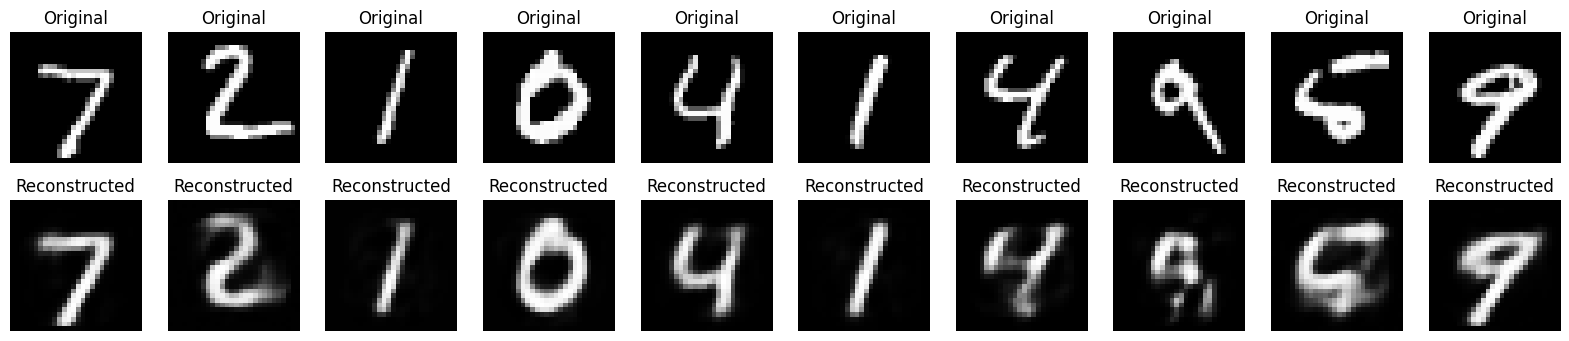

In [3]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

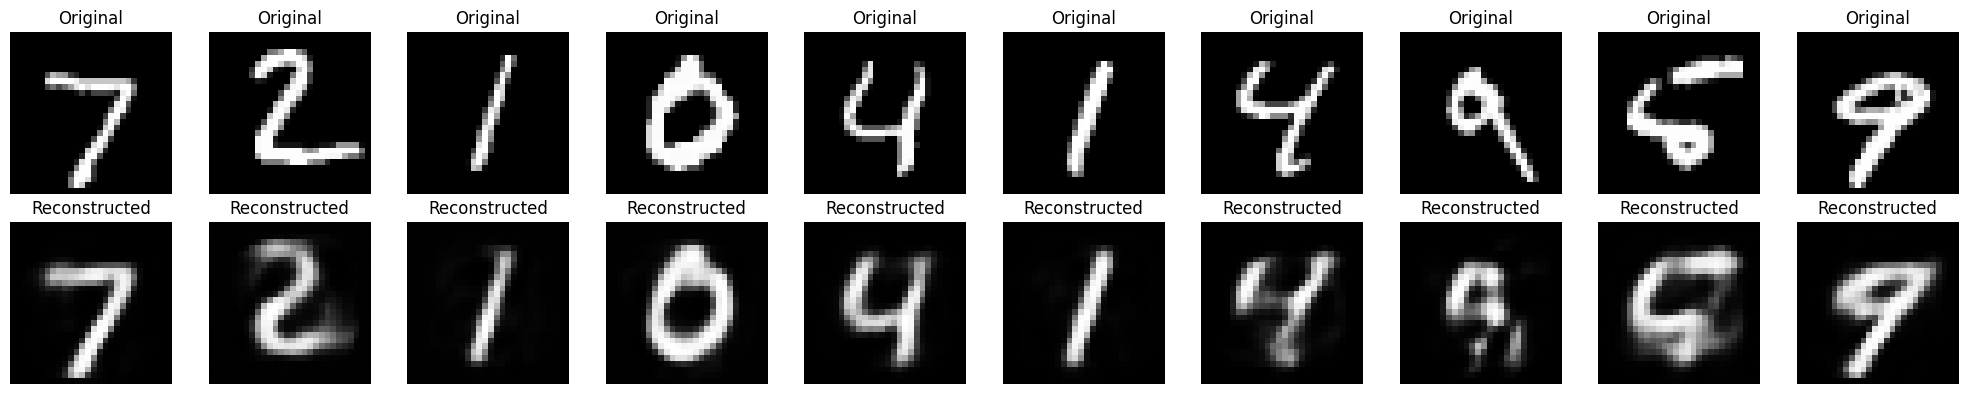

Decoder weights shape: (64, 784)


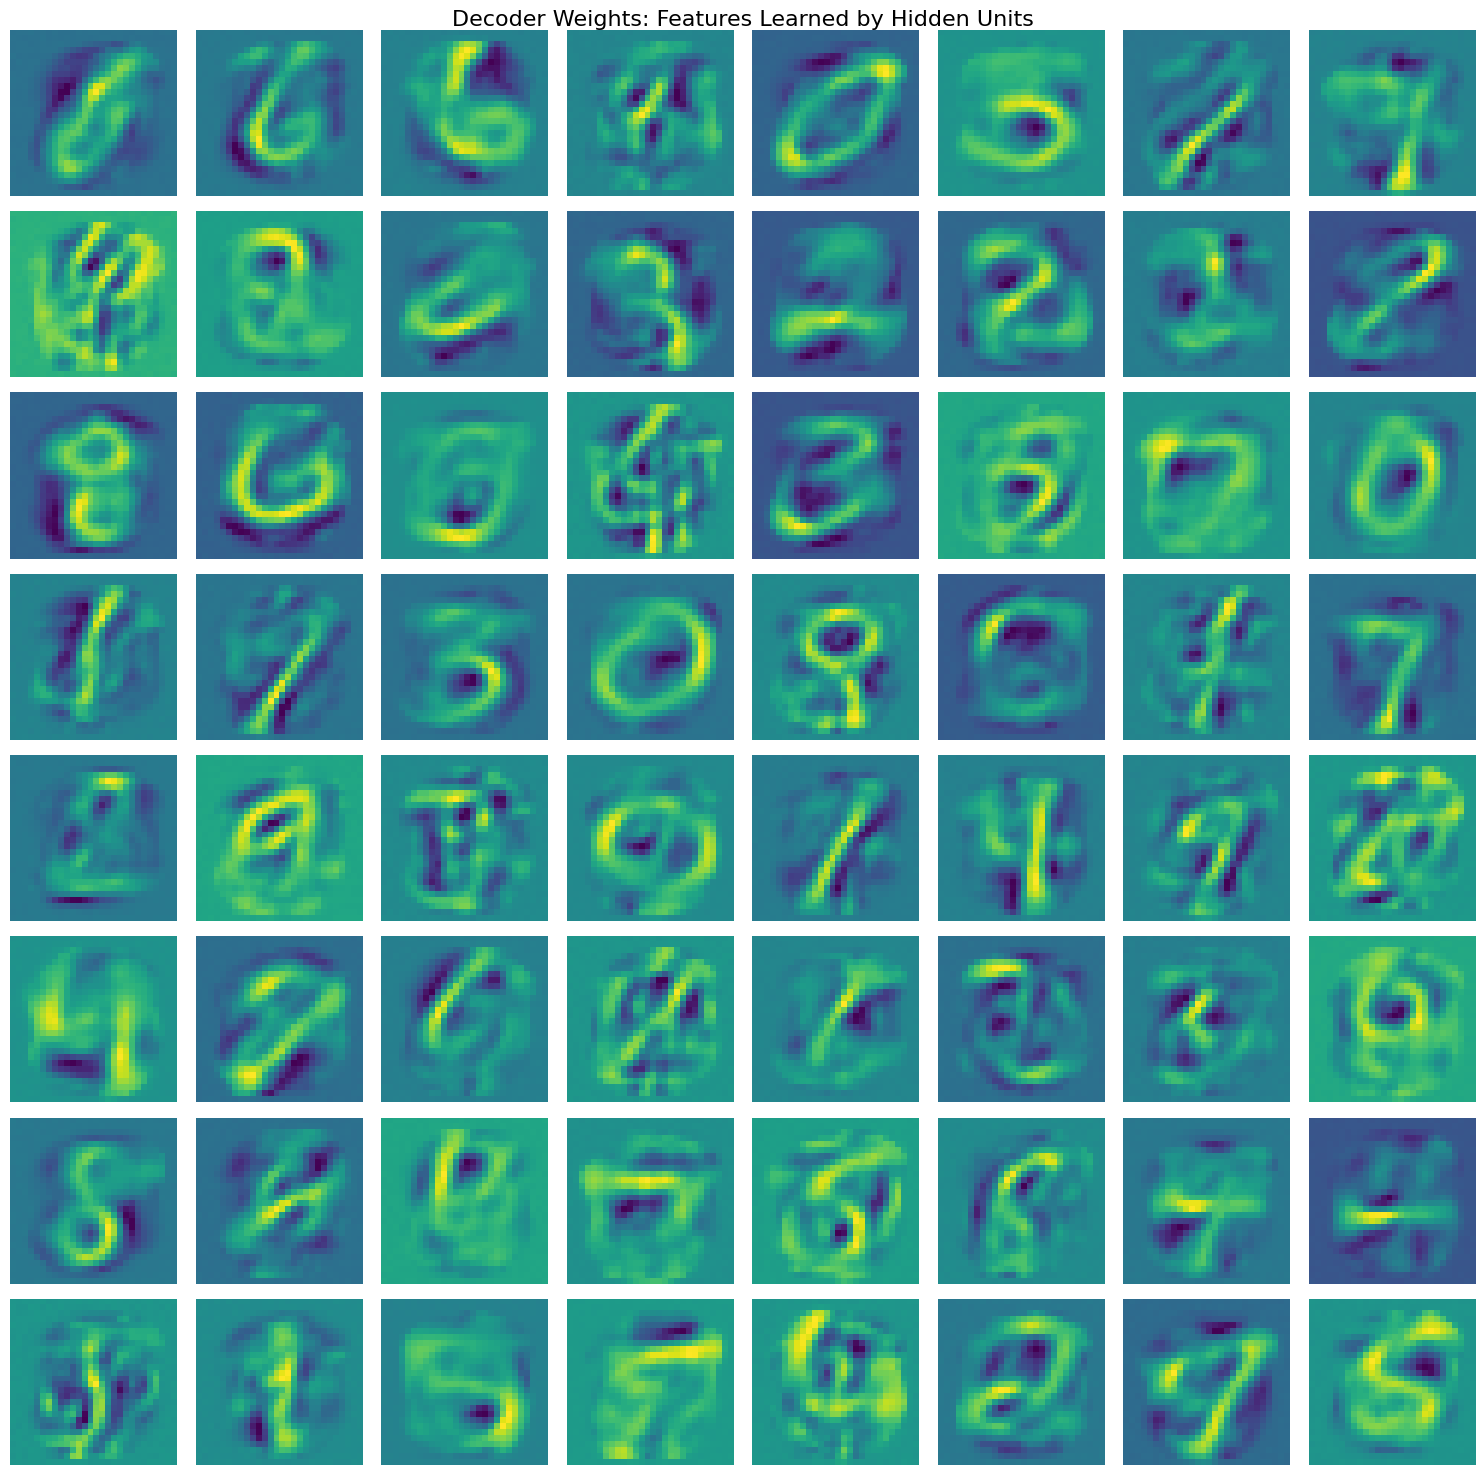

 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step

2025-10-08 11:49:54.219674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 8 bytes spill stores, 8 bytes spill loads

2025-10-08 11:49:54.281854: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 8 bytes spill stores, 8 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


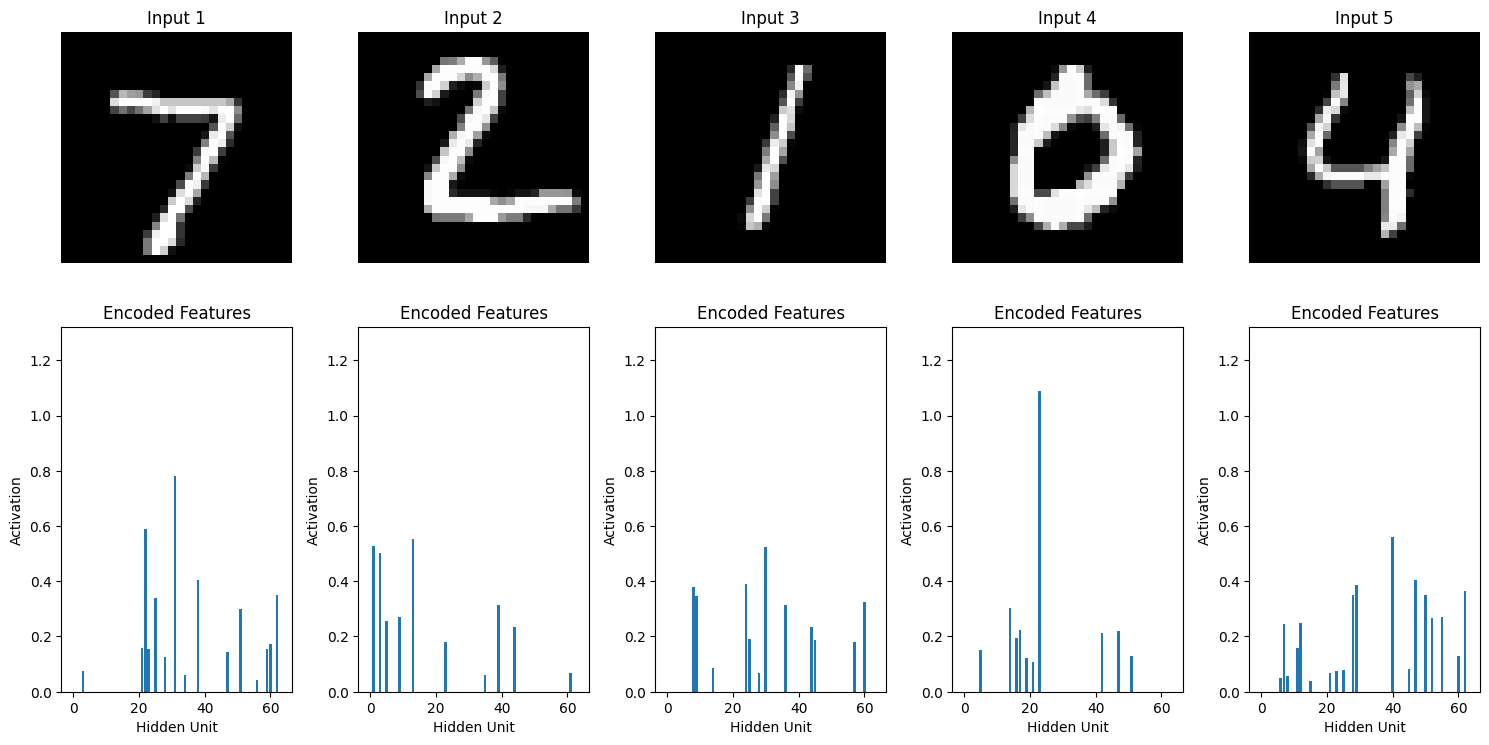

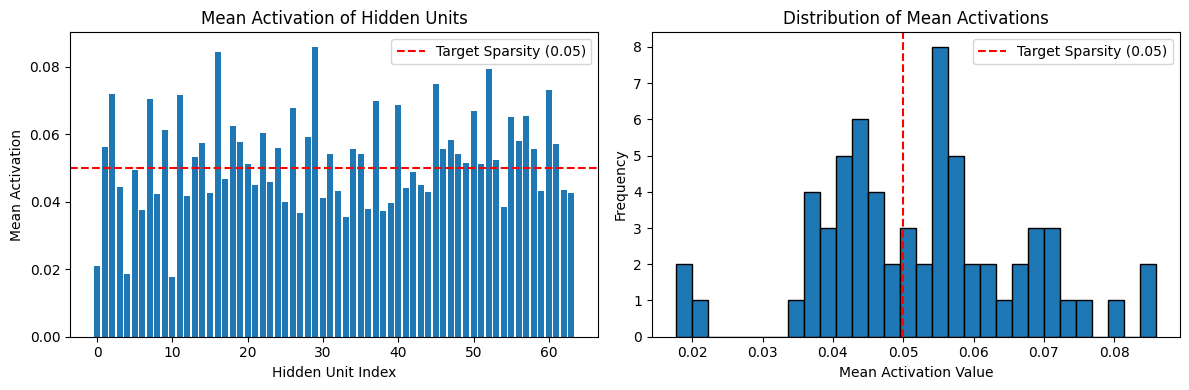

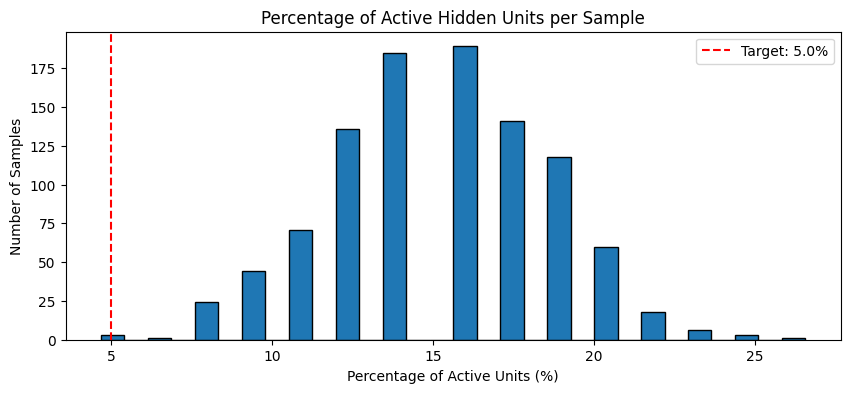

Mean percentage of active units: 15.14%
Target sparsity: 5.0%


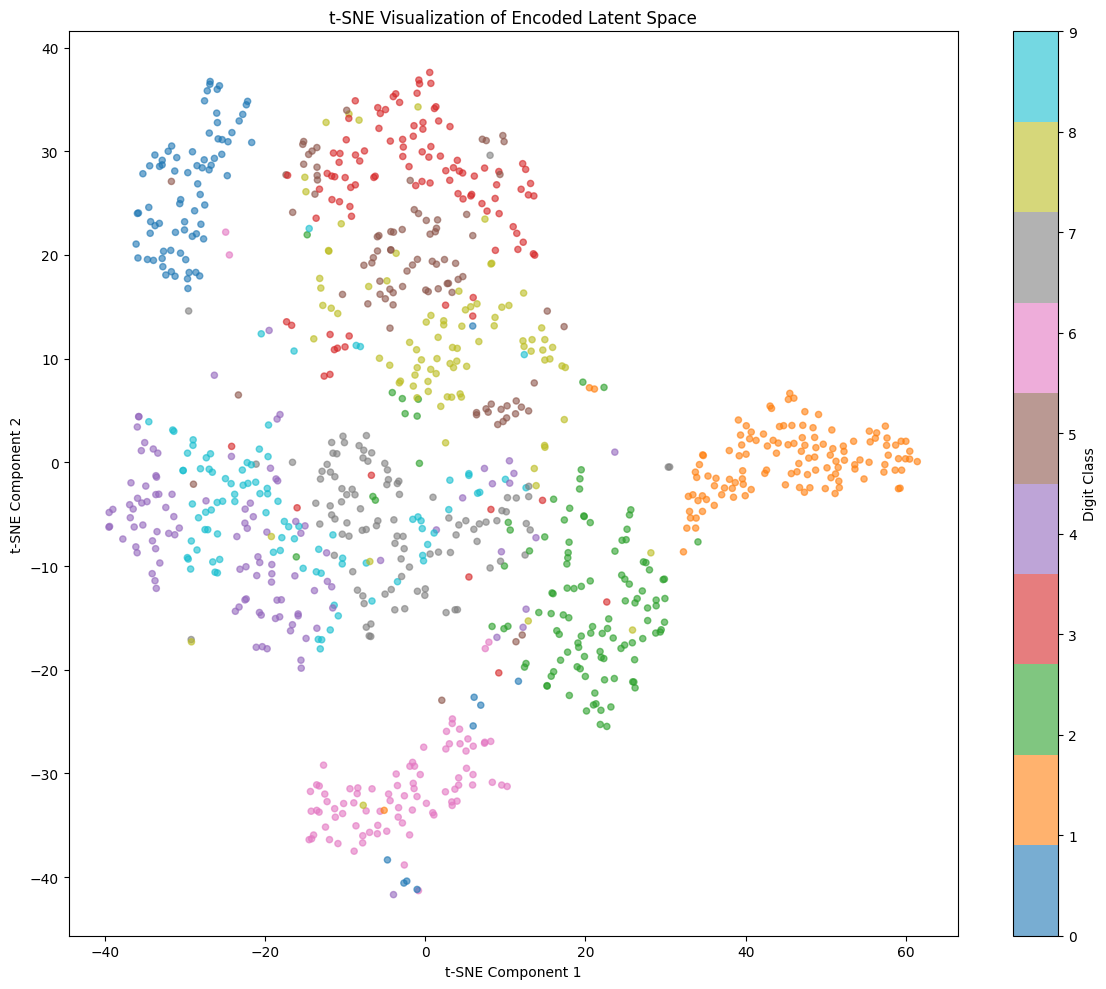

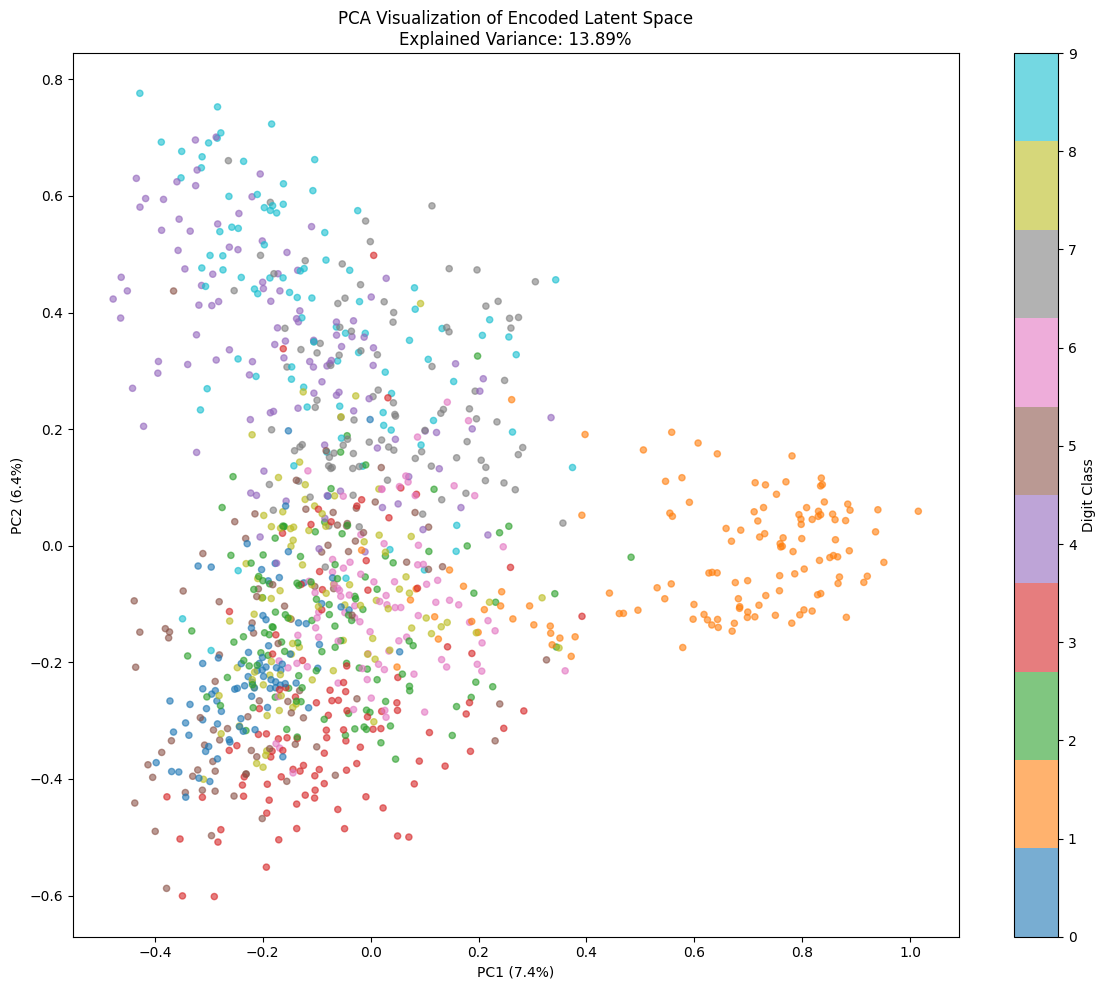

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Visualize Original vs Reconstructed Images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Visualize Decoder Weights (Features Learned by Each Hidden Unit)
decoder_weights = autoencoder.layers[-1].get_weights()[0]  # Shape: (64, 784)
print(f"Decoder weights shape: {decoder_weights.shape}")

n_features = min(64, hidden_dim)  # Show up to 64 features
grid_size = int(np.ceil(np.sqrt(n_features)))

plt.figure(figsize=(15, 15))
for i in range(n_features):
    ax = plt.subplot(grid_size, grid_size, i + 1)
    weight_image = decoder_weights[i, :].reshape(28, 28)  # Changed [:, i] to [i, :]
    plt.imshow(weight_image, cmap='viridis', interpolation='nearest')
    plt.axis('off')
plt.suptitle('Decoder Weights: Features Learned by Hidden Units', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Visualize Encoded Features for Sample Images
encoded_test = encoder.predict(x_test[:1000])

# Show activation patterns for first 5 test images
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Input {i+1}')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.bar(range(hidden_dim), encoded_test[i])
    plt.title(f'Encoded Features')
    plt.xlabel('Hidden Unit')
    plt.ylabel('Activation')
    plt.ylim([0, encoded_test.max()])
plt.tight_layout()
plt.show()

# 4. Mean Activation of Hidden Units (Verify Sparsity)
mean_activation = np.mean(encoded_test, axis=0)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(mean_activation)), mean_activation)
plt.axhline(y=sparsity_level, color='r', linestyle='--',
            label=f'Target Sparsity ({sparsity_level})')
plt.title('Mean Activation of Hidden Units')
plt.xlabel('Hidden Unit Index')
plt.ylabel('Mean Activation')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mean_activation, bins=30, edgecolor='black')
plt.axvline(x=sparsity_level, color='r', linestyle='--',
            label=f'Target Sparsity ({sparsity_level})')
plt.title('Distribution of Mean Activations')
plt.xlabel('Mean Activation Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Sparsity Analysis: Percentage of Active Units per Sample
active_threshold = 0.1  # Consider unit "active" if activation > 0.1
active_units = (encoded_test > active_threshold).sum(axis=1)
sparsity_percentage = (active_units / hidden_dim) * 100

plt.figure(figsize=(10, 4))
plt.hist(sparsity_percentage, bins=30, edgecolor='black')
plt.title('Percentage of Active Hidden Units per Sample')
plt.xlabel('Percentage of Active Units (%)')
plt.ylabel('Number of Samples')
plt.axvline(x=sparsity_level * 100, color='r', linestyle='--',
            label=f'Target: {sparsity_level*100}%')
plt.legend()
plt.show()

print(f"Mean percentage of active units: {sparsity_percentage.mean():.2f}%")
print(f"Target sparsity: {sparsity_level * 100}%")

# 6. t-SNE Visualization of Latent Space (requires labels)
# Get labels for coloring
_, (_, y_test_labels) = keras.datasets.mnist.load_data()

# Use t-SNE for high-dimensional latent space
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
encoded_2d = tsne.fit_transform(encoded_test[:1000])

plt.figure(figsize=(12, 10))
scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1],
                     c=y_test_labels[:1000], cmap='tab10',
                     alpha=0.6, s=20)
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Encoded Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

# 7. PCA Visualization (alternative to t-SNE, faster)
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_test[:1000])

plt.figure(figsize=(12, 10))
scatter = plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1],
                     c=y_test_labels[:1000], cmap='tab10',
                     alpha=0.6, s=20)
plt.colorbar(scatter, label='Digit Class')
plt.title(f'PCA Visualization of Encoded Latent Space\n'
          f'Explained Variance: {pca.explained_variance_ratio_.sum():.2%}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.tight_layout()
plt.show()


Which is pretty cool.

# SAE

I define the class like so:

In [9]:
import torch.nn as nn

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, lambda_sparse=0, k_param=20) -> None:
        super(SparseAutoencoder, self).__init__()
        self.training = True
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lambda_sparse = lambda_sparse
        self.k_param = k_param

        # Encoder maps input to hidden representation
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )

        # Decoder maps hidden representation back to input space
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        x_hat = self.decoder(h)
        return h, x_hat

    def k_sparse_loss(self, h, k):
        # h: batch of activations (batch_size x n)
        topk_vals, topk_idx = torch.topk(h, k, dim=1)

        # Create mask for top-k activations
        mask = torch.zeros_like(h)
        mask.scatter_(1, topk_idx, 1)

        # Get all activations outside top-k
        non_topk_activations = h * (1 - mask)

        # Sparsity penalty: sum of absolute values of the non top-k activations
        sparsity_penalty = torch.sum(torch.abs(non_topk_activations))

        return sparsity_penalty

    def compute_loss(self, x, h, x_hat):
        # 1. Reconstruction Loss: (1/d) * ||x - x_hat||^2_2
        # We compute sum of squares and normalize by input dimension 'd'
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # 2. Sparsity Loss: lambda * L_sparse(h)
        sparse_penalty = self.k_sparse_loss(h, self.k_param)
        sparse_loss = self.lambda_sparse * sparse_penalty

        # Total Loss
        total_loss = recon_loss + sparse_loss

        return total_loss, sparse_loss


Initialize everything needed:

In [10]:
import torchvision
import torchvision.transforms as transforms

# Data loading and preprocessing - normalize to [0,1] instead [0,255]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def train_sparse_autoencoder(
        learning_rate=0.001,
        num_epochs=50,
        batch_size=256,
        hidden_size=64,
        lambda_sparse=0.1,
        k_param=20):

    # Initialize model
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    model = SparseAutoencoder(input_size=784, hidden_size=hidden_size, lambda_sparse=lambda_sparse, k_param=k_param).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('Training Sparse Autoencoder')
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_sparse_loss = 0.0
        for data in trainloader:
            inputs, _ = data
            inputs = inputs.view(-1, 28*28).to(device)
            optimizer.zero_grad()
            h, outputs = model(inputs)
            loss, sparse_loss = model.compute_loss(inputs, h, outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_sparse_loss += sparse_loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Sparse Loss: {running_sparse_loss/len(trainloader):.4f}')
    print('Finished training')
    weights = model.encoder[0].weight.data.cpu().numpy()
    plt.figure(figsize=(8, 8))
    for i in range(hidden_size):
        plt.subplot(8, 8, i + 1)
        plt.imshow(weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()


Training Sparse Autoencoder
Epoch [1/50], Loss: 86.1015, Sparse Loss: 50.1131
Epoch [2/50], Loss: 21.8540, Sparse Loss: 4.1261
Epoch [3/50], Loss: 17.7531, Sparse Loss: 1.9497
Epoch [4/50], Loss: 15.6433, Sparse Loss: 1.1899
Epoch [5/50], Loss: 14.2054, Sparse Loss: 0.8163
Epoch [6/50], Loss: 13.0782, Sparse Loss: 0.5992
Epoch [7/50], Loss: 12.1383, Sparse Loss: 0.4599
Epoch [8/50], Loss: 11.3383, Sparse Loss: 0.3641
Epoch [9/50], Loss: 10.6470, Sparse Loss: 0.2949
Epoch [10/50], Loss: 10.0499, Sparse Loss: 0.2431
Epoch [11/50], Loss: 9.5306, Sparse Loss: 0.2031
Epoch [12/50], Loss: 9.0609, Sparse Loss: 0.1716
Epoch [13/50], Loss: 8.6586, Sparse Loss: 0.1462
Epoch [14/50], Loss: 8.3195, Sparse Loss: 0.1256
Epoch [15/50], Loss: 8.0196, Sparse Loss: 0.1085
Epoch [16/50], Loss: 7.7418, Sparse Loss: 0.0942
Epoch [17/50], Loss: 7.4807, Sparse Loss: 0.0821
Epoch [18/50], Loss: 7.2291, Sparse Loss: 0.0719
Epoch [19/50], Loss: 6.9857, Sparse Loss: 0.0631
Epoch [20/50], Loss: 6.7627, Sparse Los

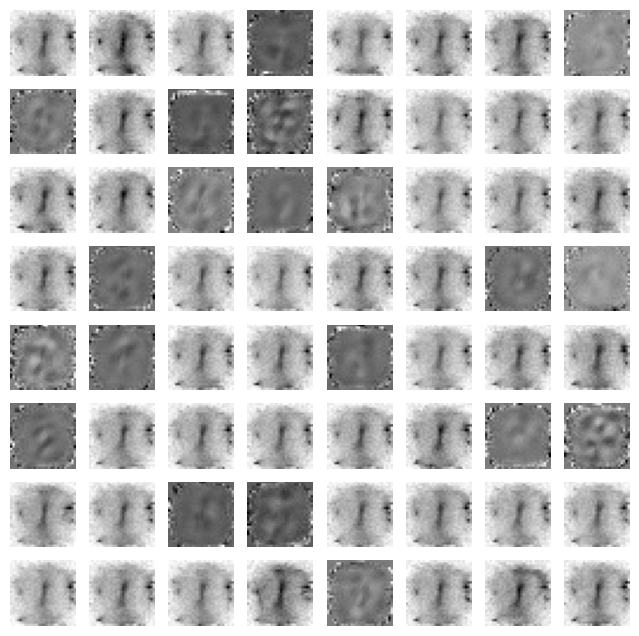

In [14]:
train_sparse_autoencoder()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=512, k_param=20):

        super(SparseAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_param = k_param

        # Pre-activation bias (decoder bias learned separately)
        self.b_pre = nn.Parameter(torch.zeros(input_size))

        # Encoder: linear projection only
        self.encoder = nn.Linear(input_size, hidden_size, bias=True)

        # Decoder: linear projection back to input space
        self.decoder = nn.Linear(hidden_size, input_size, bias=False)

        # Initialize decoder columns to unit norm
        with torch.no_grad():
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=0)

        # MSE normalization constant (computed during first batch)
        self.register_buffer('mse_norm', torch.tensor(1.0))
        self.mse_computed = False

    def forward(self, x):
        # Center input using pre-activation bias
        x_centered = x

        # Encoder: linear projection
        h_pre = self.encoder(x_centered)

        # Apply ReLU to ensure non-negative activations
        h_pre = F.relu(h_pre)

        # TopK activation: keep only k largest activations per sample
        topk_vals, topk_idx = torch.topk(h_pre, self.k_param, dim=1)

        # Create sparse activation tensor
        h = torch.zeros_like(h_pre)
        h.scatter_(1, topk_idx, topk_vals)

        # Decoder: reconstruct input
        x_hat = self.decoder(h)

        return h, x_hat

    def compute_loss(self, x, x_hat):
        mse = F.mse_loss(x_hat, x, reduction='mean')

        return mse

    def compute_mse_normalization(self, dataloader, device, num_batches=100):
        """
        Compute MSE normalization constant from data variance.

        Args:
            dataloader: Training data loader
            device: Device to compute on
            num_batches: Number of batches to sample
        """
        all_data = []
        for i, (data, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            all_data.append(data.view(-1, self.input_size))

        all_data = torch.cat(all_data, dim=0).to(device)
        self.mse_norm.data = torch.var(all_data)
        self.mse_computed = True
        print(f"MSE normalization constant: {self.mse_norm.item():.6f}")


def train_topk_sparse_autoencoder(
    learning_rate=0.0005,
    num_epochs=100,
    batch_size=256,
    hidden_size=512,
    k_param=20,
    device='cuda'):
    """
    Train TopK sparse autoencoder on MNIST.

    Args:
        learning_rate: Learning rate for Adam optimizer
        num_epochs: Number of training epochs
        batch_size: Batch size
        hidden_size: Number of latent features
        k_param: Sparsity level (number of active features)
        device: Device to train on
    """
    # Data loading
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.LFWPeople(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize model
    model = SparseAutoencoder(
        input_size=784,
        hidden_size=hidden_size,
        k_param=k_param
    ).to(device)

    # Compute MSE normalization constant
    print("Computing MSE normalization constant...")
    model.compute_mse_normalization(trainloader, device)

    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    print(f'\nTraining TopK Sparse Autoencoder')
    print(f'Hidden size: {hidden_size}, K: {k_param}, L0: {k_param/hidden_size:.2%}')
    print('-' * 60)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_l0 = 0.0

        for data in trainloader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)

            optimizer.zero_grad()

            # Forward pass
            h, x_hat = model(inputs)
            loss = model.compute_loss(inputs, x_hat)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Normalize decoder weights to unit norm after each update
            with torch.no_grad():
                model.decoder.weight.data = F.normalize(model.decoder.weight.data, dim=0)

            running_loss += loss.item()
            running_l0 += (h != 0).float().mean().item() * model.hidden_size

        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        avg_l0 = running_l0 / len(trainloader)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
                  f'Avg L0: {avg_l0:.1f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    print('Finished training')

    return model


def visualize_decoder_features(model, hidden_size, n_display=64):
    """Visualize decoder weight columns (what each feature contributes to reconstruction)."""
    model.eval()
    decoder_weights = model.decoder.weight.data.cpu().numpy().T  # (hidden_size, input_size)

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nDecoder Features (what each latent adds to reconstruction):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(decoder_weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Decoder Weight Columns (Dictionary Atoms)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('decoder_features.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_encoder_features(model, hidden_size, n_display=64):
    """Visualize encoder weight rows (what input patterns each latent responds to)."""
    model.eval()
    encoder_weights = model.encoder.weight.data.cpu().numpy()  # (hidden_size, input_size)

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nEncoder Features (what patterns activate each latent):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        # Normalize each encoder weight for better visualization
        weight = encoder_weights[i].reshape(28, 28)
        weight = (weight - weight.min()) / (weight.max() - weight.min() + 1e-8)
        plt.imshow(weight, cmap='viridis')
        plt.axis('off')
    plt.suptitle('Encoder Weight Rows (Feature Detectors)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('encoder_features.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_reconstructions(model, testloader, device, n_samples=10):
    """Compare original and reconstructed images side-by-side."""
    model.eval()

    # Get a batch of test images
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Calculate per-sample reconstruction error
        errors = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()

        # Calculate sparsity (number of active features)
        l0_counts = (h != 0).float().sum(dim=1).cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nReconstruction Comparison:")
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Original\nLabel: {labels[i].item()}', fontsize=9)
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title(f'Recon\nL0: {int(l0_counts[i])}\nMSE: {errors[i]:.4f}', fontsize=9)
        plt.axis('off')

    plt.suptitle('Original vs Reconstructed Images', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_activation_patterns(model, testloader, device, n_samples=5):
    """Visualize which features activate for specific input images."""
    model.eval()

    # Get a few test images
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Get activation patterns
        h = h.cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nActivation Patterns for Sample Images:")
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

    for i in range(n_samples):
        # Original image
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original (Label: {labels[i].item()})', fontsize=10)
        axes[i, 0].axis('off')

        # Reconstructed image
        axes[i, 1].imshow(reconstructed[i], cmap='gray')
        axes[i, 1].set_title('Reconstructed', fontsize=10)
        axes[i, 1].axis('off')

        # Activation pattern (which features are active)
        active_features = np.where(h[i] > 0)[0]
        activation_visual = np.zeros(model.hidden_size)
        activation_visual[active_features] = h[i][active_features]

        axes[i, 2].bar(range(len(activation_visual)), activation_visual, width=1.0)
        axes[i, 2].set_title(f'Active Features ({len(active_features)} features)', fontsize=10)
        axes[i, 2].set_xlabel('Feature Index')
        axes[i, 2].set_ylabel('Activation Strength')
        axes[i, 2].set_xlim([0, model.hidden_size])

        # Top 3 active features visualization
        top_k_idx = np.argsort(h[i])[-3:][::-1]
        decoder_weights = model.decoder.weight.data.cpu().numpy().T

        combined_feature = np.zeros((28, 28))
        for idx in top_k_idx:
            if h[i][idx] > 0:
                combined_feature += h[i][idx] * decoder_weights[idx].reshape(28, 28)

        axes[i, 3].imshow(combined_feature, cmap='gray')
        axes[i, 3].set_title(f'Top 3 Features Combined\n({top_k_idx[0]}, {top_k_idx[1]}, {top_k_idx[2]})', fontsize=9)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('activation_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()


def compare_encoder_decoder_relationship(model, n_display=8):
    """Compare encoder and decoder weights for the same features."""
    model.eval()

    encoder_weights = model.encoder.weight.data.cpu().numpy()  # (hidden_size, input_size)
    decoder_weights = model.decoder.weight.data.cpu().numpy().T  # (hidden_size, input_size)

    # Select random features to display
    indices = np.random.choice(model.hidden_size, n_display, replace=False)

    print("\nEncoder-Decoder Weight Comparison:")
    plt.figure(figsize=(16, 4))

    for i, idx in enumerate(indices):
        # Encoder weight
        plt.subplot(2, n_display, i + 1)
        enc_weight = encoder_weights[idx].reshape(28, 28)
        enc_weight = (enc_weight - enc_weight.min()) / (enc_weight.max() - enc_weight.min() + 1e-8)
        plt.imshow(enc_weight, cmap='viridis')
        plt.title(f'Enc {idx}', fontsize=9)
        plt.axis('off')

        # Decoder weight
        plt.subplot(2, n_display, n_display + i + 1)
        dec_weight = decoder_weights[idx].reshape(28, 28)
        plt.imshow(dec_weight, cmap='gray')
        plt.title(f'Dec {idx}', fontsize=9)
        plt.axis('off')

    plt.suptitle('Encoder (top) vs Decoder (bottom) Weights for Same Features', fontsize=12)
    plt.tight_layout()
    plt.savefig('encoder_decoder_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()




let's gather some data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


testing k values - other kept constant


Training with k=10
Computing MSE normalization constant...
MSE normalization constant: 0.094840

Training TopK Sparse Autoencoder
Hidden size: 64, K: 10, L0: 15.62%
------------------------------------------------------------
Epoch [5/50], Loss: 0.0274, Avg L0: 10.0, LR: 0.000488
Epoch [10/50], Loss: 0.0264, Avg L0: 10.0, LR: 0.000452
Epoch [15/50], Loss: 0.0259, Avg L0: 10.0, LR: 0.000397
Epoch [20/50], Loss: 0.0256, Avg L0: 10.0, LR: 0.000327
Epoch [25/50], Loss: 0.0252, Avg L0: 10.0, LR: 0.000250
Epoch [30/50], Loss: 0.0249, Avg L0: 10.0, LR: 0.000173
Epoch [35/50], Loss: 0.0246, Avg L0: 10.0, LR: 0.000103
Epoch [40/50], Loss: 0.0245, Avg L0: 10.0, LR: 0.000048
Epoch [45/50], Loss: 0.0244, Avg L0: 10.0, LR: 0.000012
Epoch [50/50], Loss: 0.0244, Avg L0: 10.0, LR: 0.000000
Finished training

Decoder Features (what each latent adds to reconstruction):


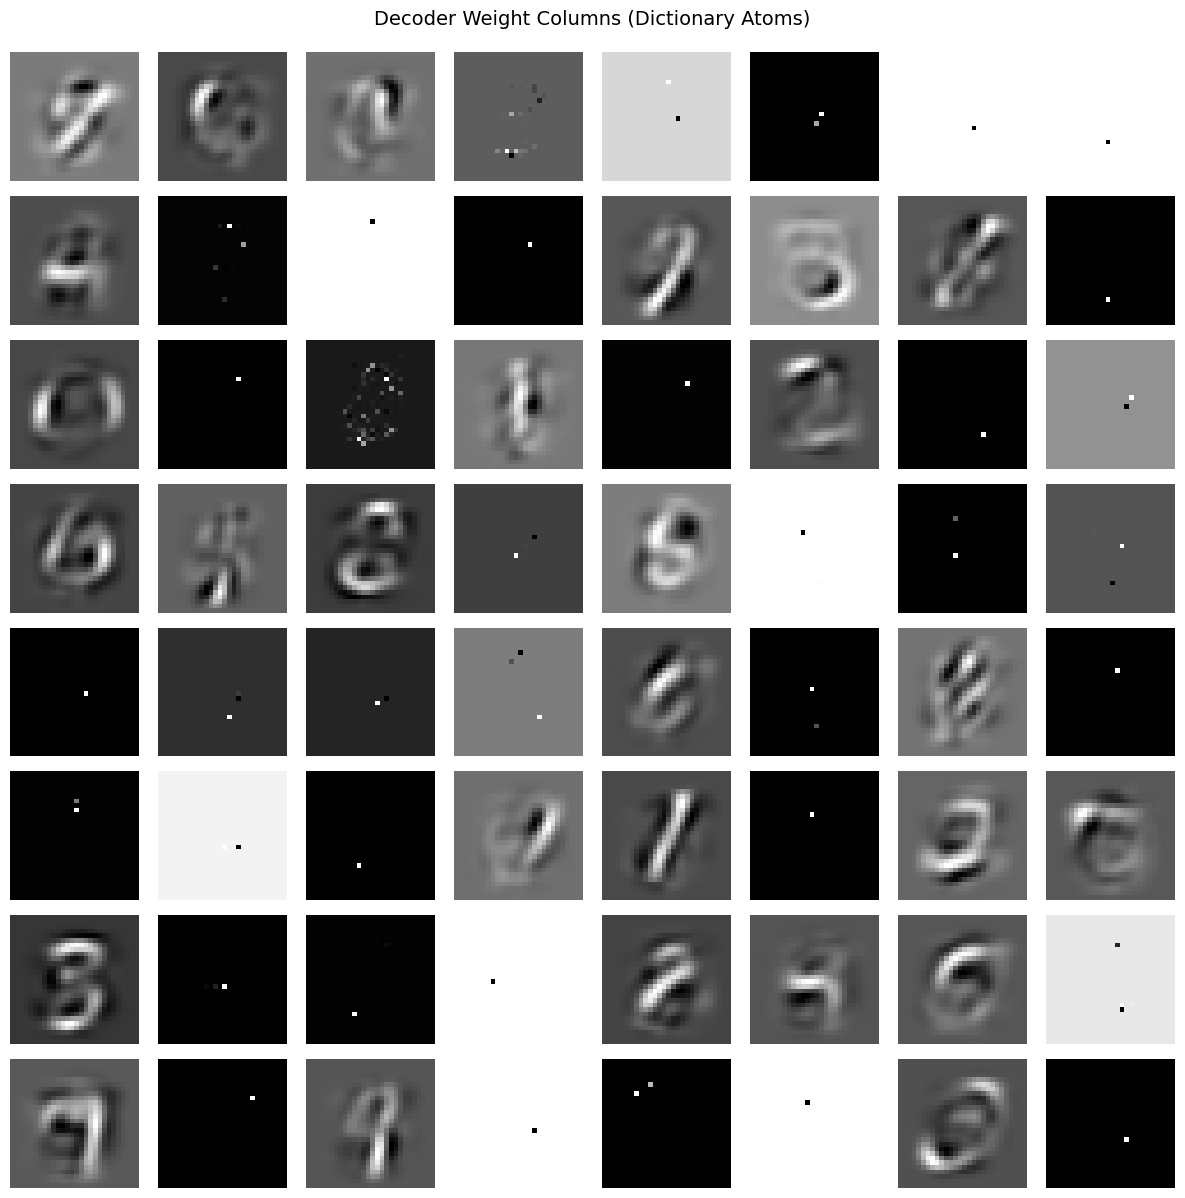


Encoder Features (what patterns activate each latent):


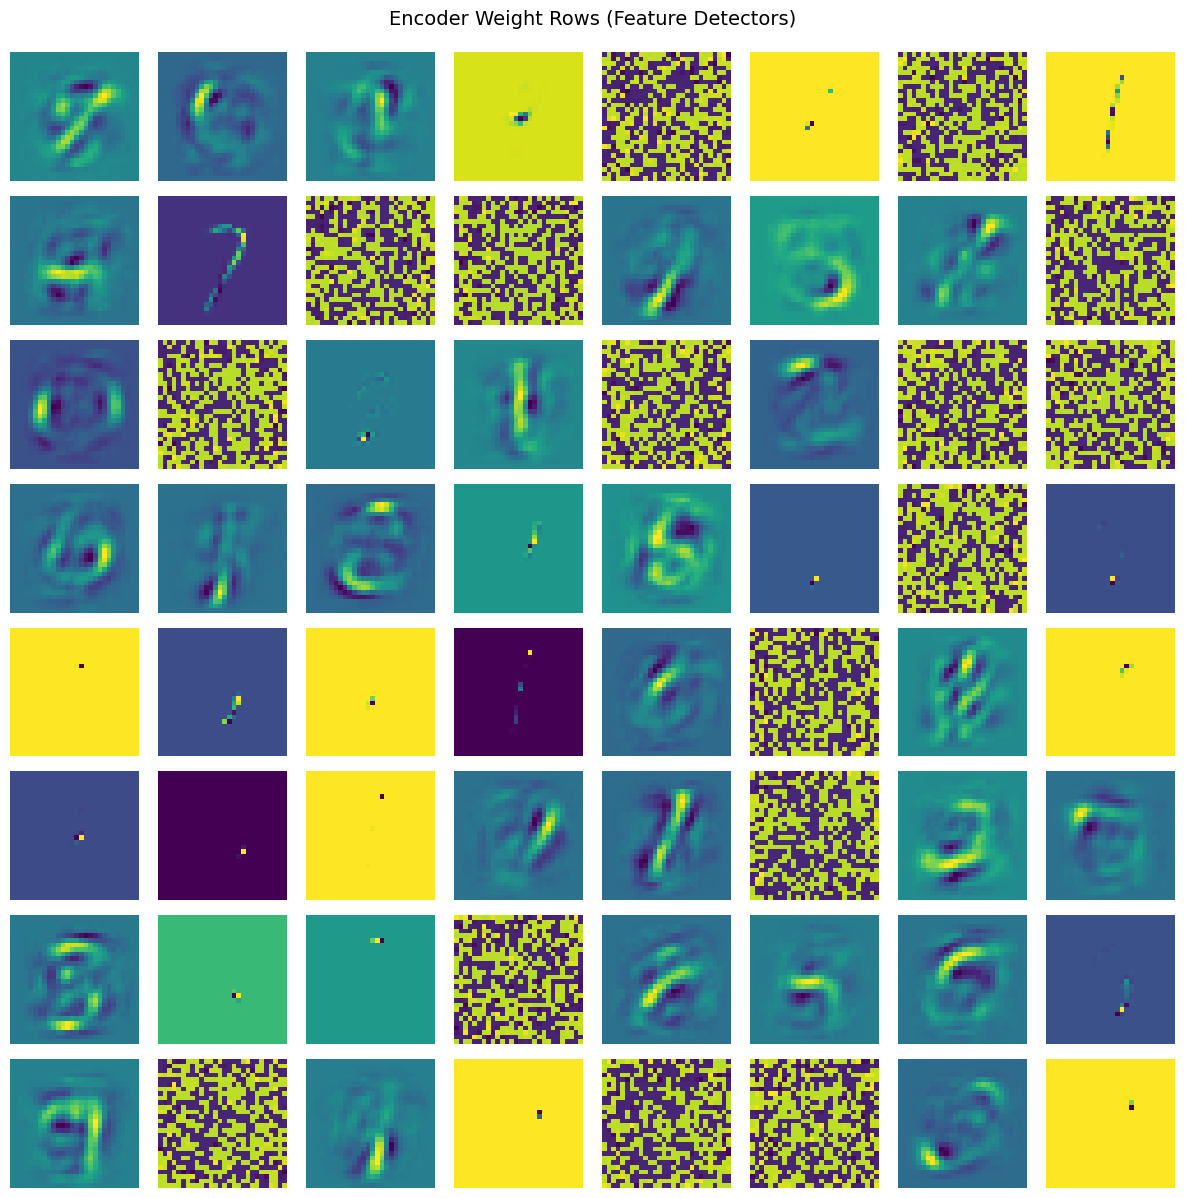


Reconstruction Comparison:


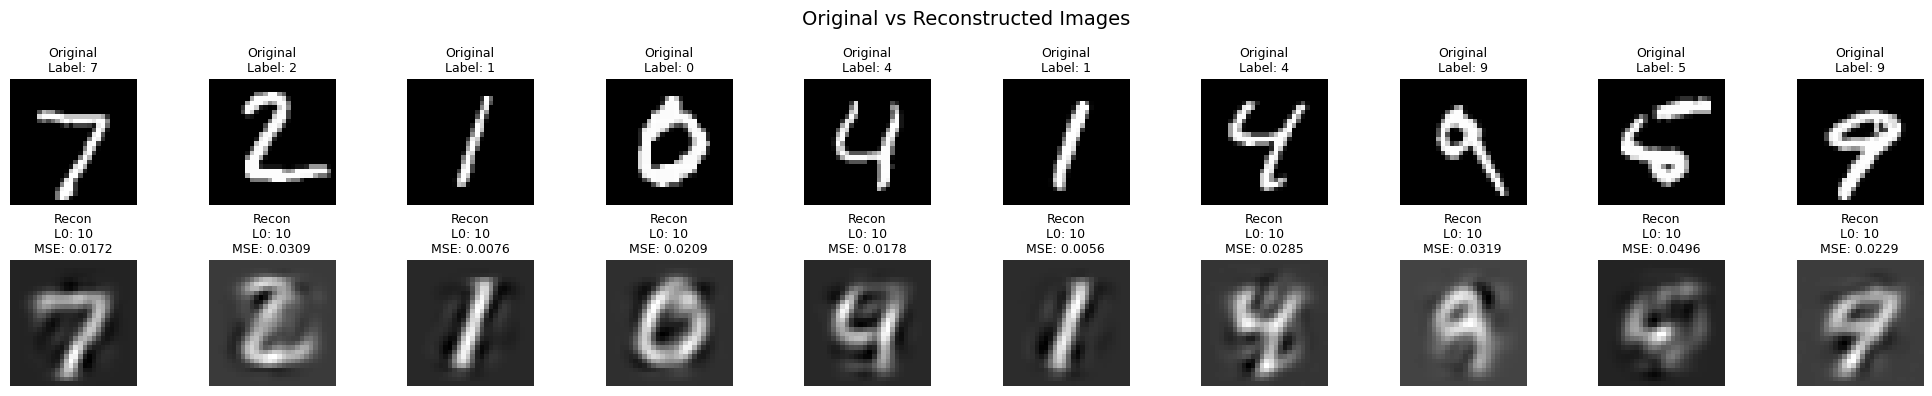


Activation Patterns for Sample Images:


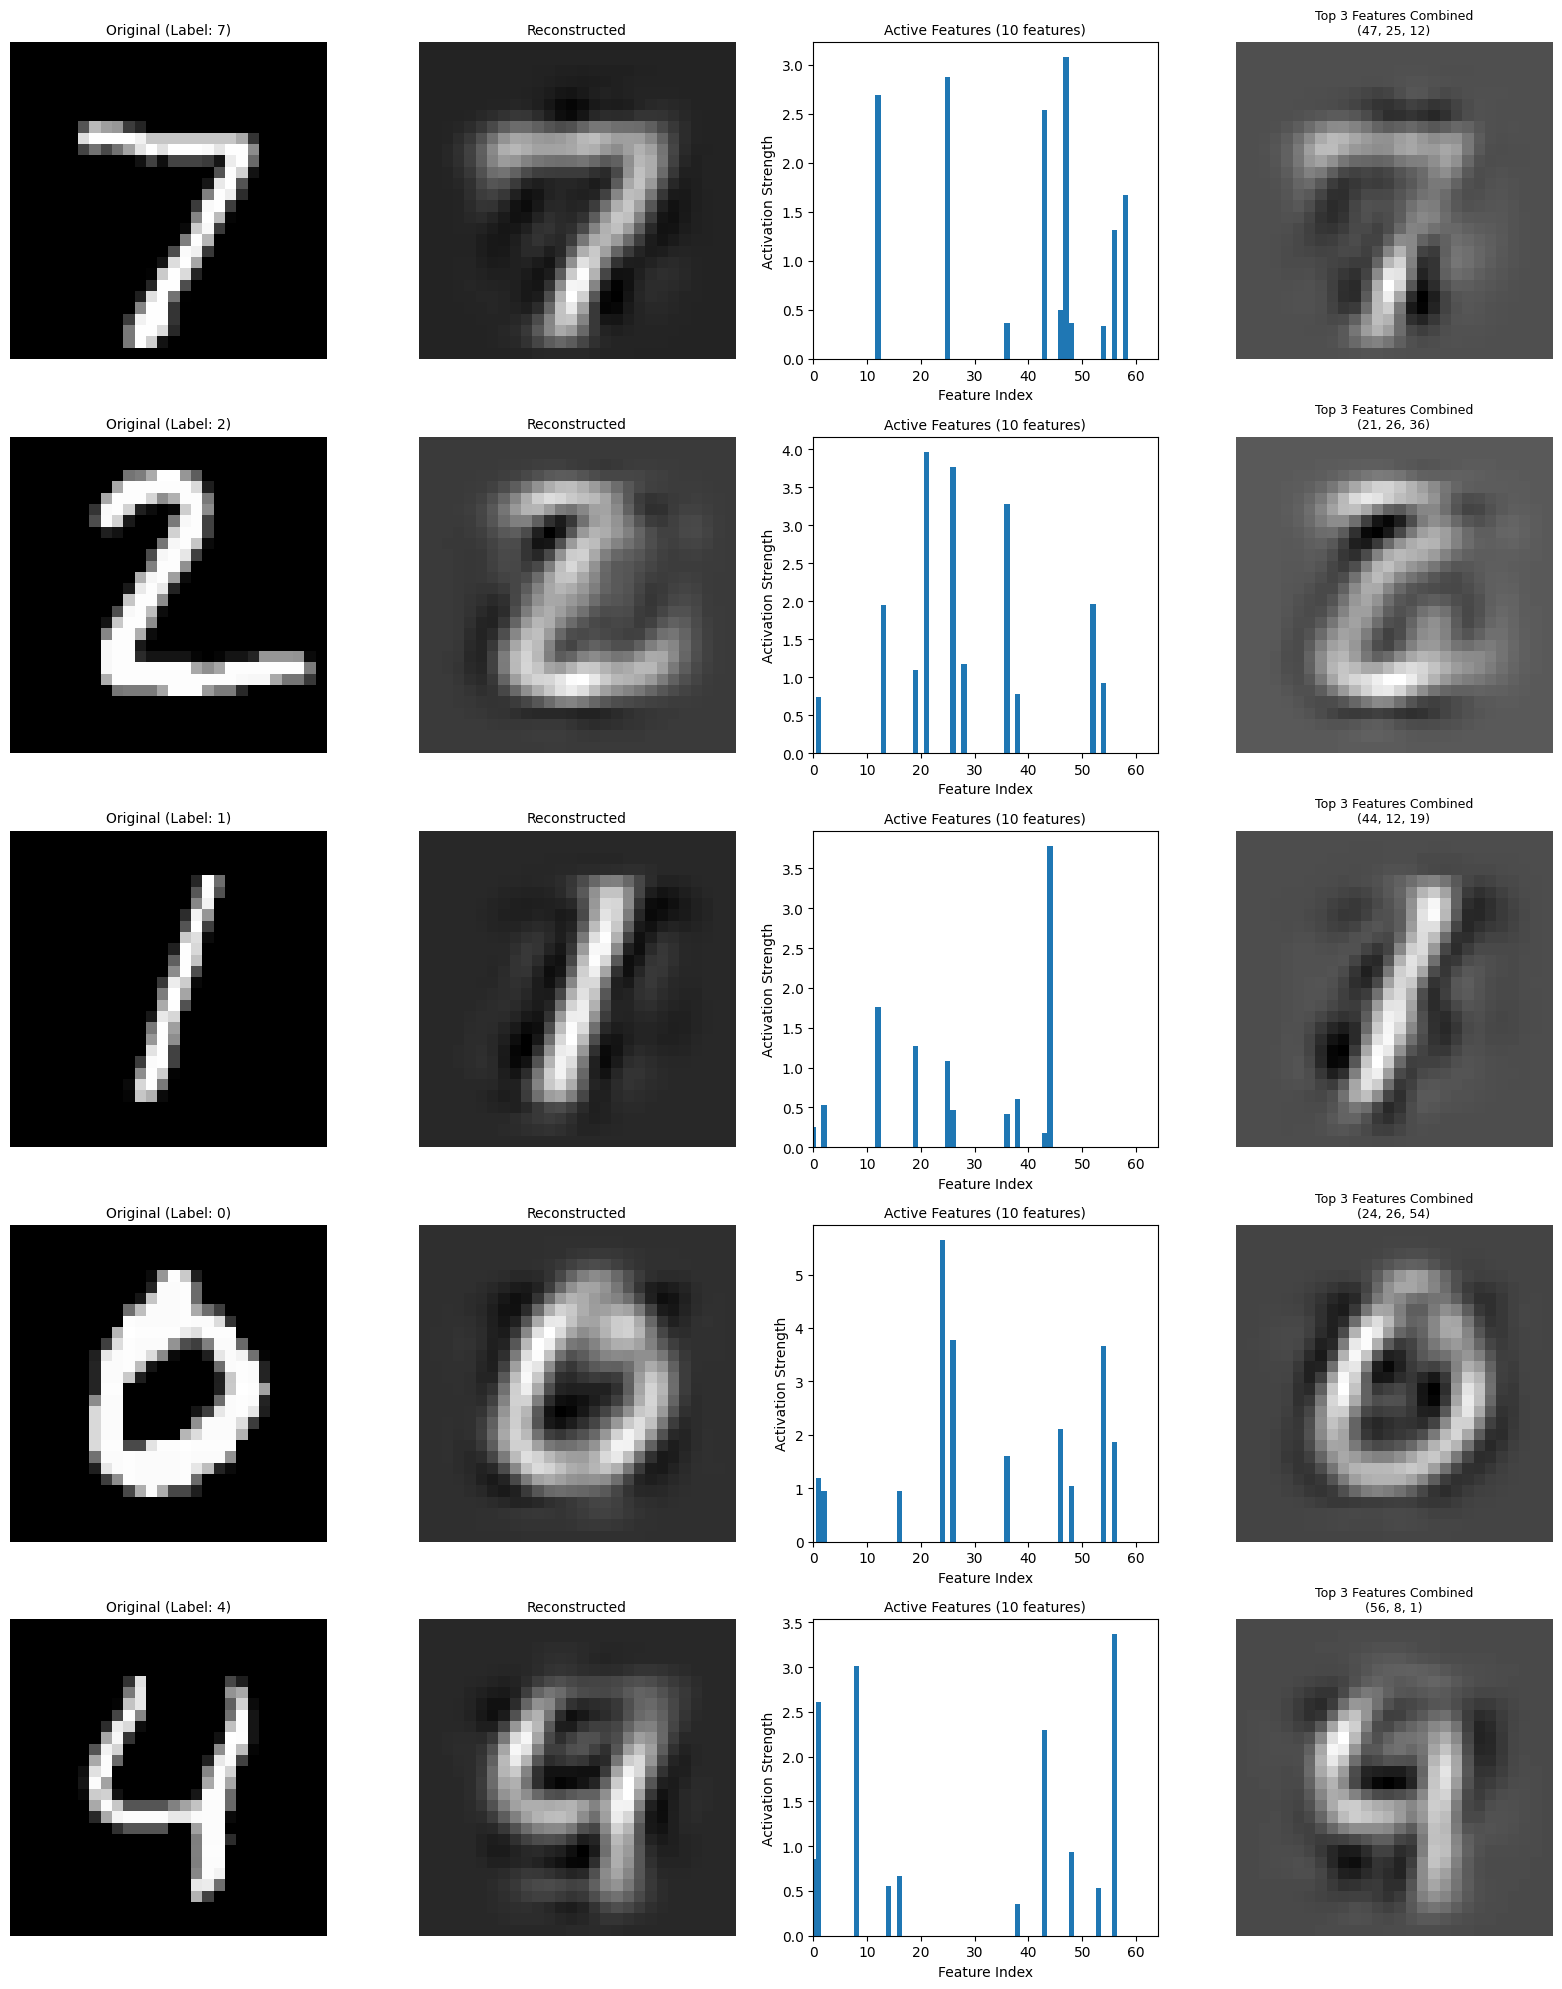


Encoder-Decoder Weight Comparison:


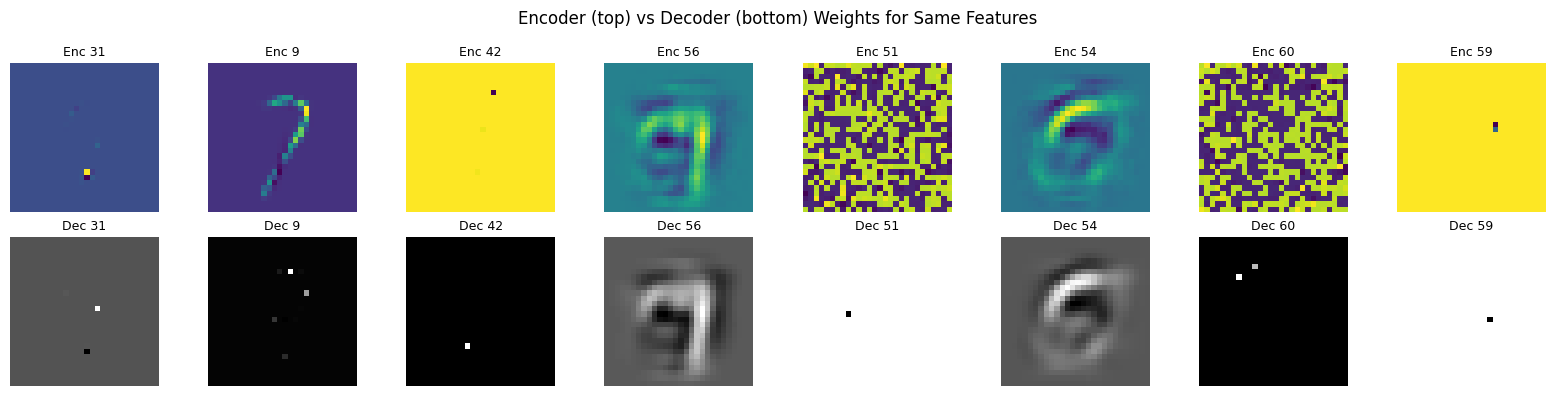


Training with k=20
Computing MSE normalization constant...
MSE normalization constant: 0.094935

Training TopK Sparse Autoencoder
Hidden size: 64, K: 20, L0: 31.25%
------------------------------------------------------------
Epoch [5/50], Loss: 0.0203, Avg L0: 20.0, LR: 0.000488
Epoch [10/50], Loss: 0.0190, Avg L0: 20.0, LR: 0.000452
Epoch [15/50], Loss: 0.0180, Avg L0: 20.0, LR: 0.000397
Epoch [20/50], Loss: 0.0176, Avg L0: 20.0, LR: 0.000327
Epoch [25/50], Loss: 0.0175, Avg L0: 20.0, LR: 0.000250
Epoch [30/50], Loss: 0.0174, Avg L0: 20.0, LR: 0.000173
Epoch [35/50], Loss: 0.0173, Avg L0: 20.0, LR: 0.000103
Epoch [40/50], Loss: 0.0173, Avg L0: 20.0, LR: 0.000048
Epoch [45/50], Loss: 0.0173, Avg L0: 20.0, LR: 0.000012
Epoch [50/50], Loss: 0.0173, Avg L0: 20.0, LR: 0.000000
Finished training

Decoder Features (what each latent adds to reconstruction):


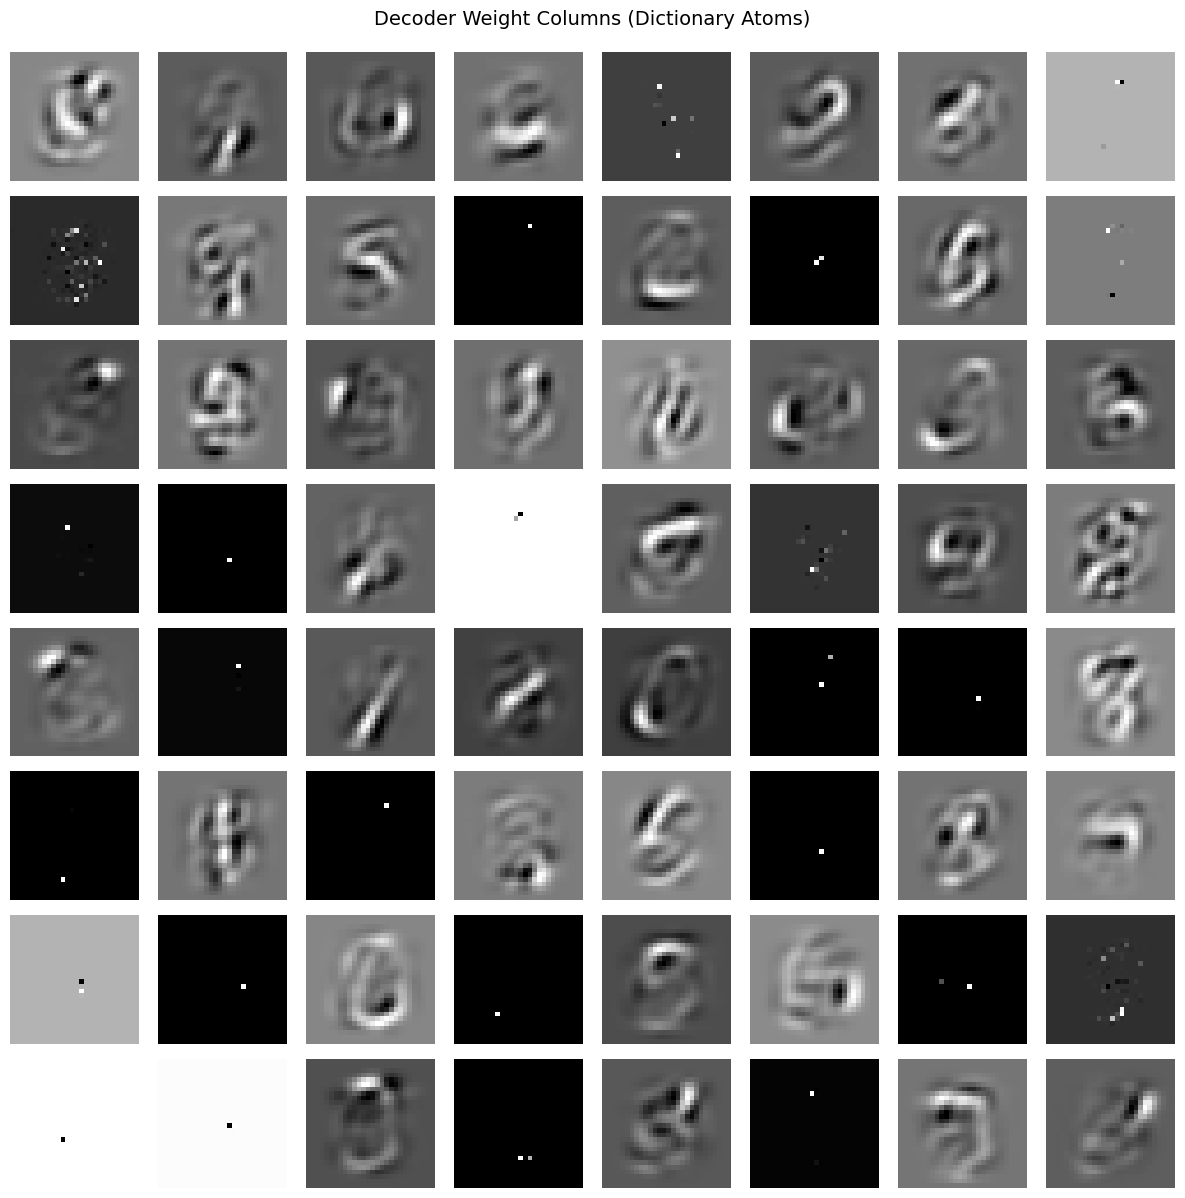


Encoder Features (what patterns activate each latent):


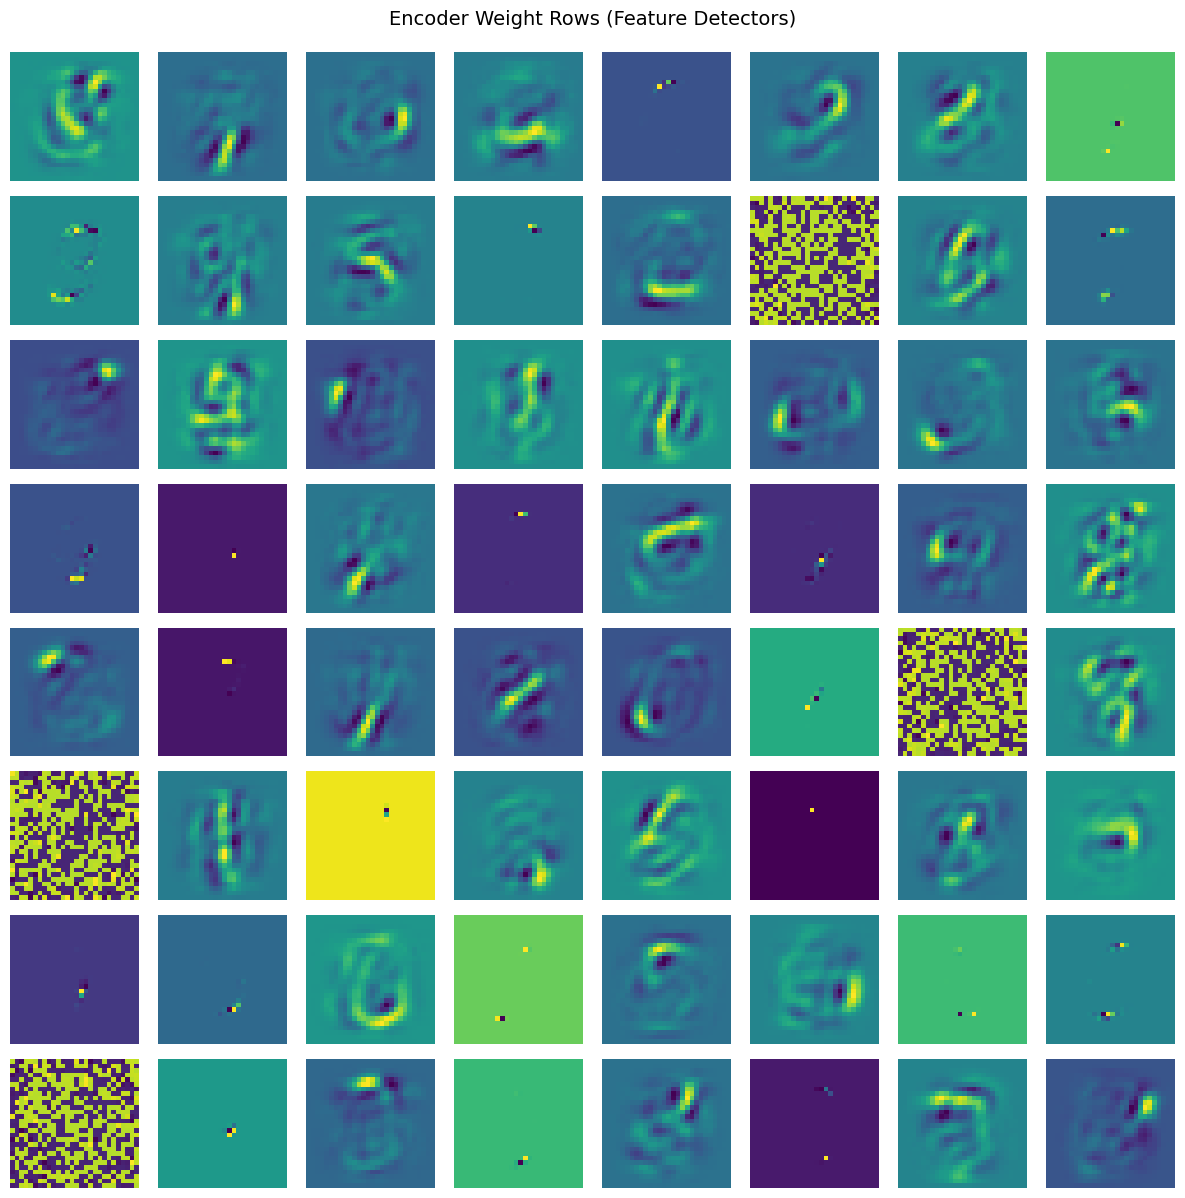


Reconstruction Comparison:


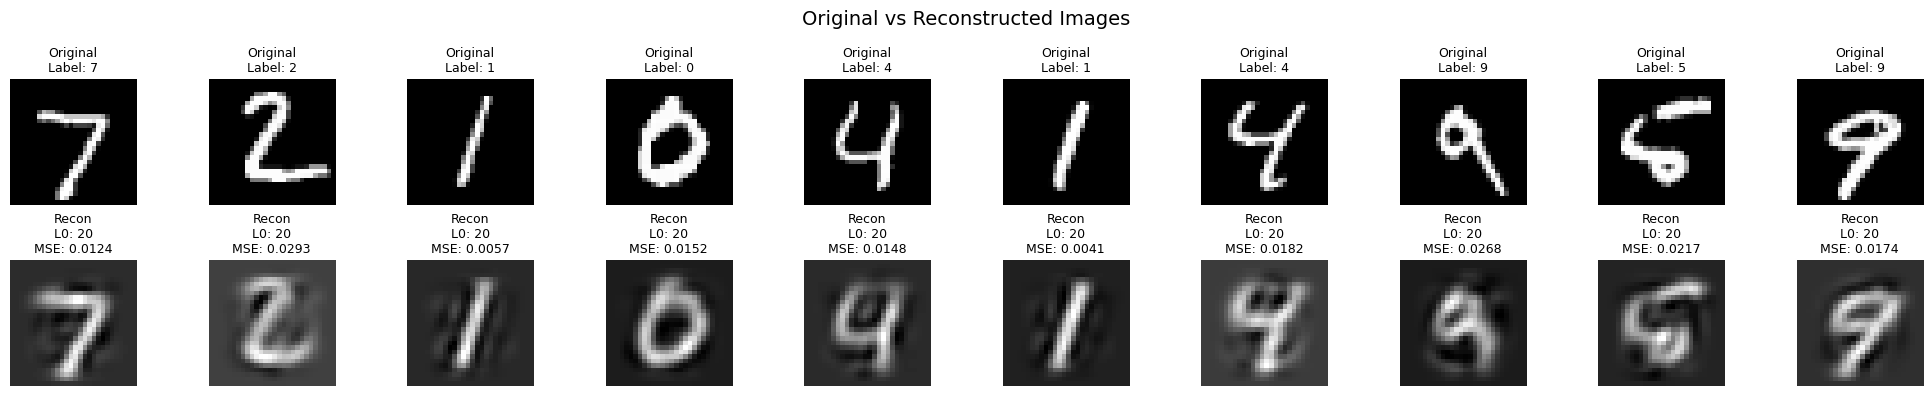


Activation Patterns for Sample Images:


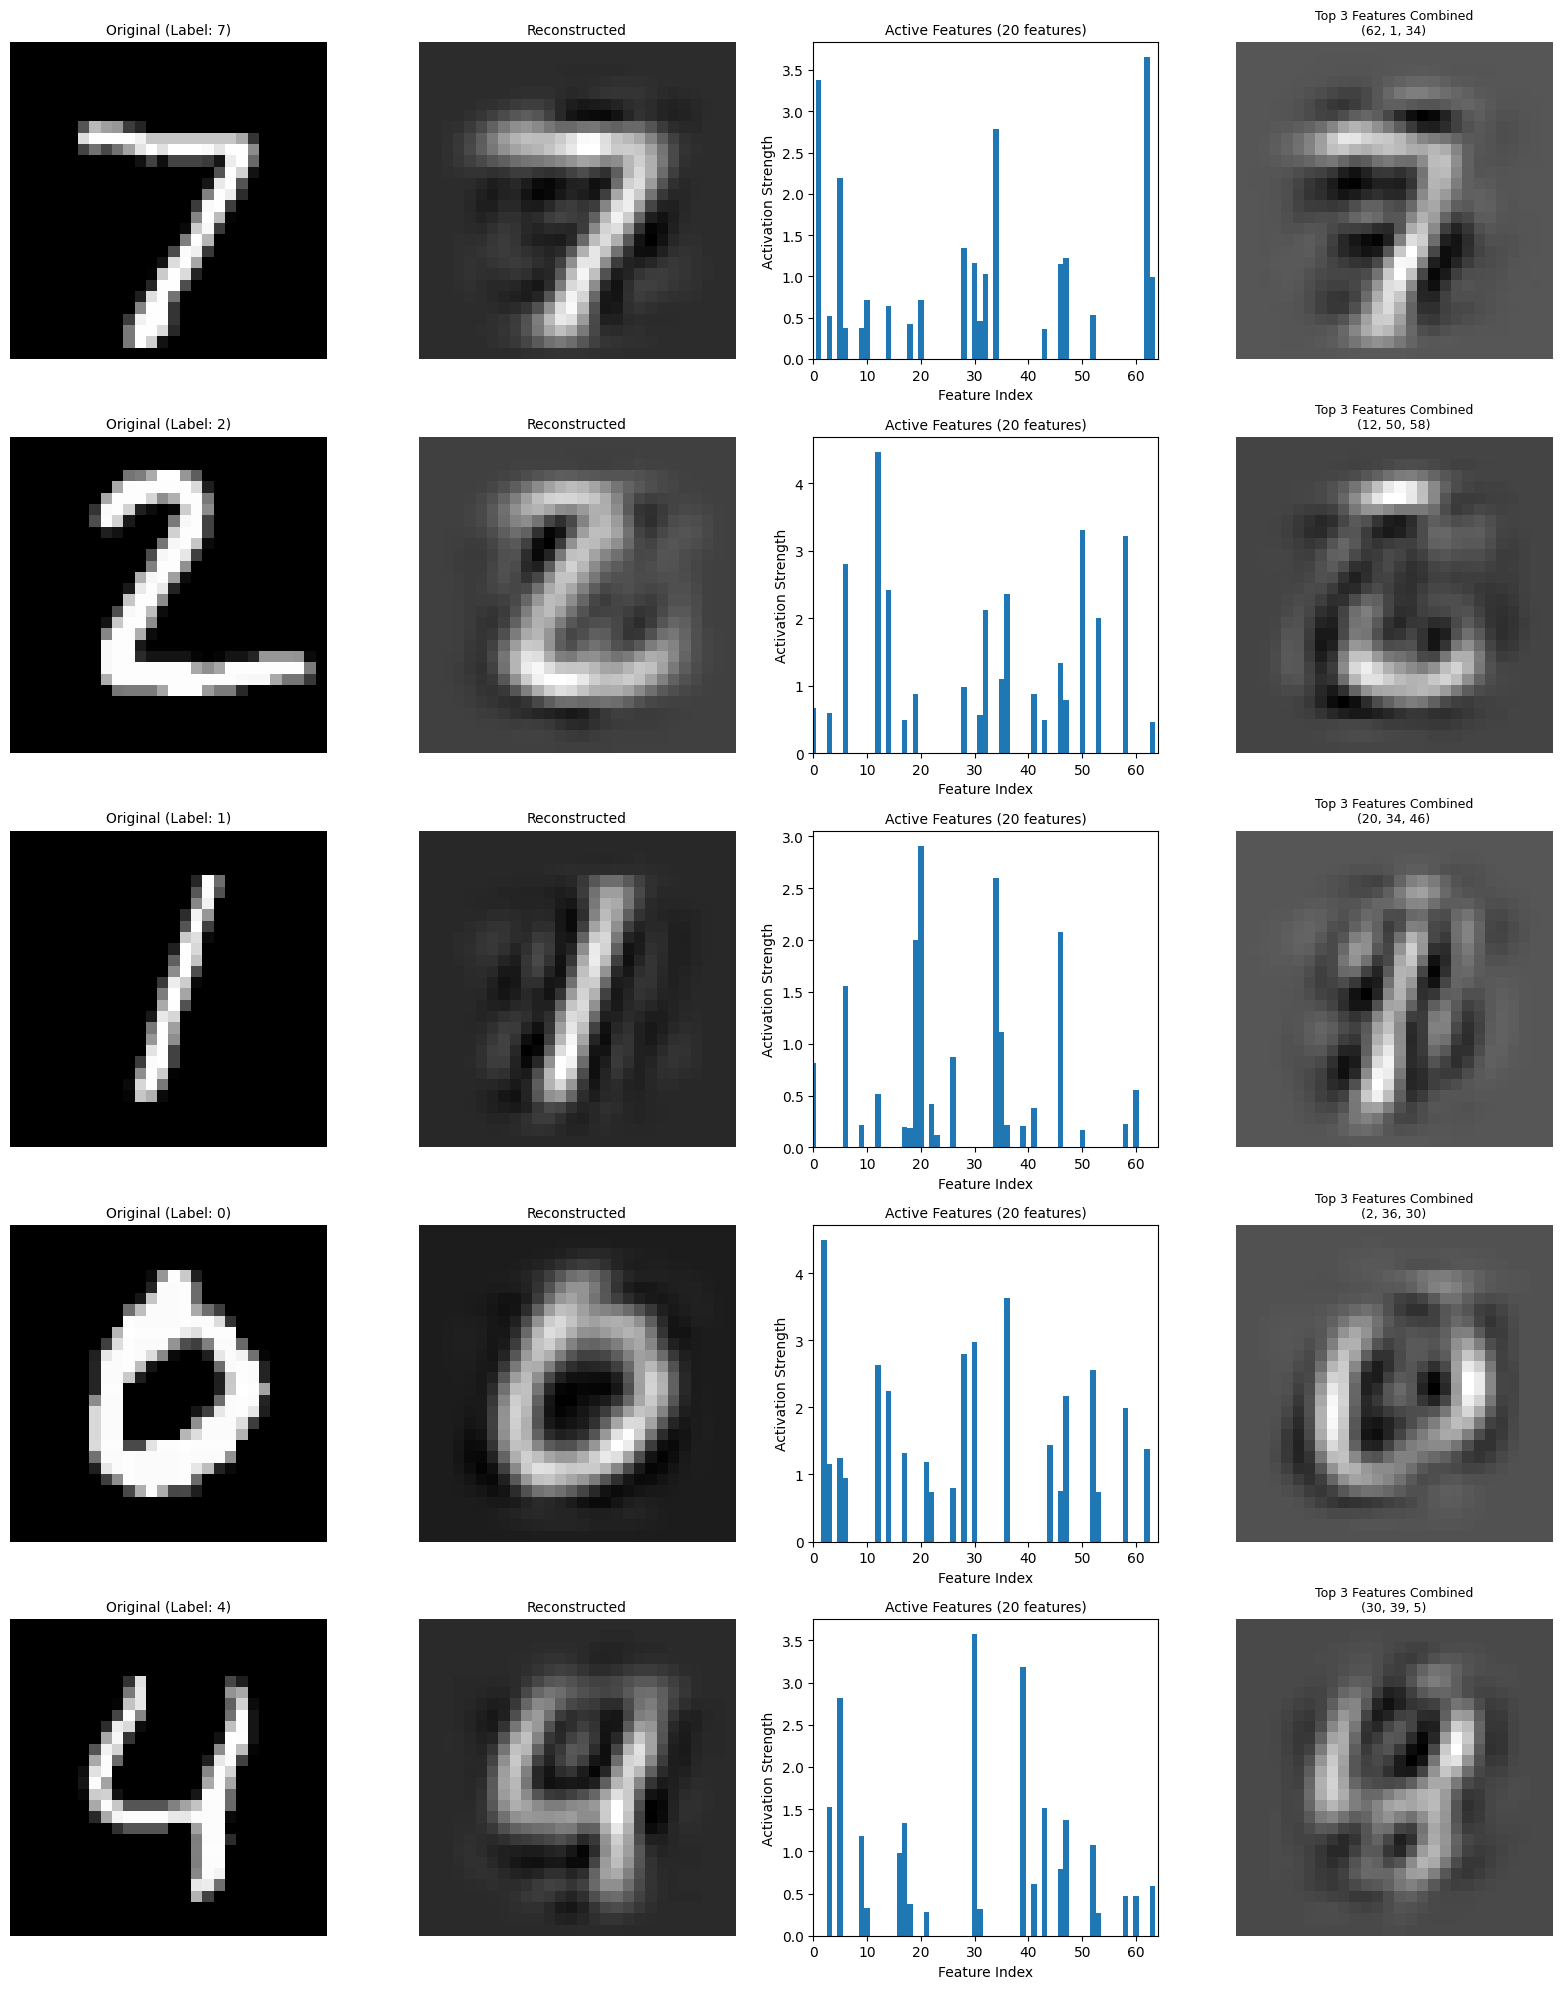


Encoder-Decoder Weight Comparison:


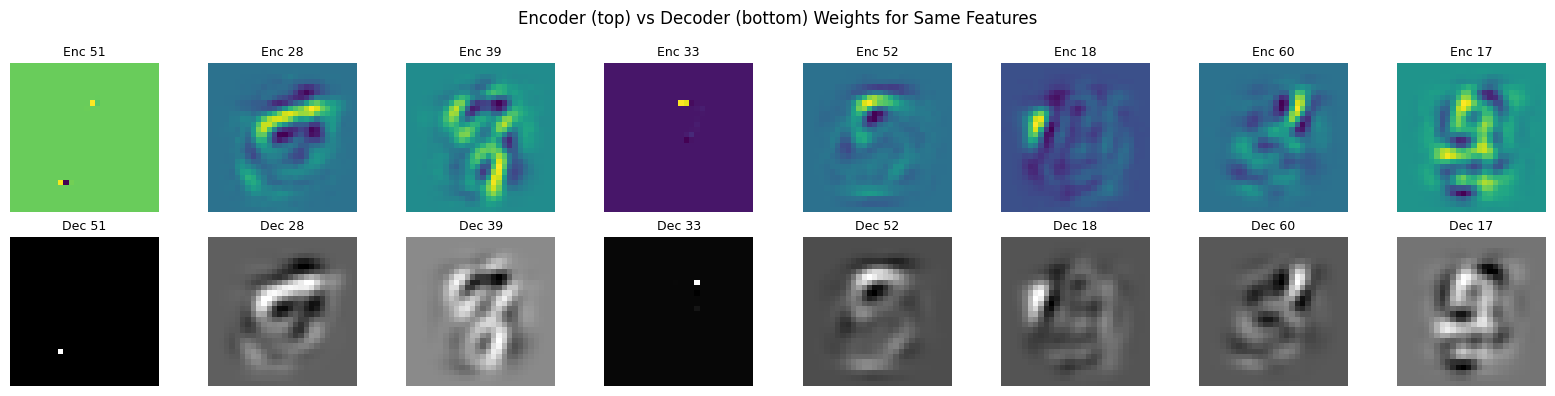


Training with k=64
Computing MSE normalization constant...
MSE normalization constant: 0.094960

Training TopK Sparse Autoencoder
Hidden size: 64, K: 64, L0: 100.00%
------------------------------------------------------------
Epoch [5/50], Loss: 0.0113, Avg L0: 59.6, LR: 0.000488
Epoch [10/50], Loss: 0.0099, Avg L0: 61.6, LR: 0.000452
Epoch [15/50], Loss: 0.0098, Avg L0: 61.7, LR: 0.000397
Epoch [20/50], Loss: 0.0097, Avg L0: 61.7, LR: 0.000327
Epoch [25/50], Loss: 0.0097, Avg L0: 61.7, LR: 0.000250
Epoch [30/50], Loss: 0.0097, Avg L0: 61.8, LR: 0.000173
Epoch [35/50], Loss: 0.0097, Avg L0: 61.8, LR: 0.000103
Epoch [40/50], Loss: 0.0096, Avg L0: 61.8, LR: 0.000048
Epoch [45/50], Loss: 0.0096, Avg L0: 61.8, LR: 0.000012
Epoch [50/50], Loss: 0.0096, Avg L0: 61.9, LR: 0.000000
Finished training

Decoder Features (what each latent adds to reconstruction):


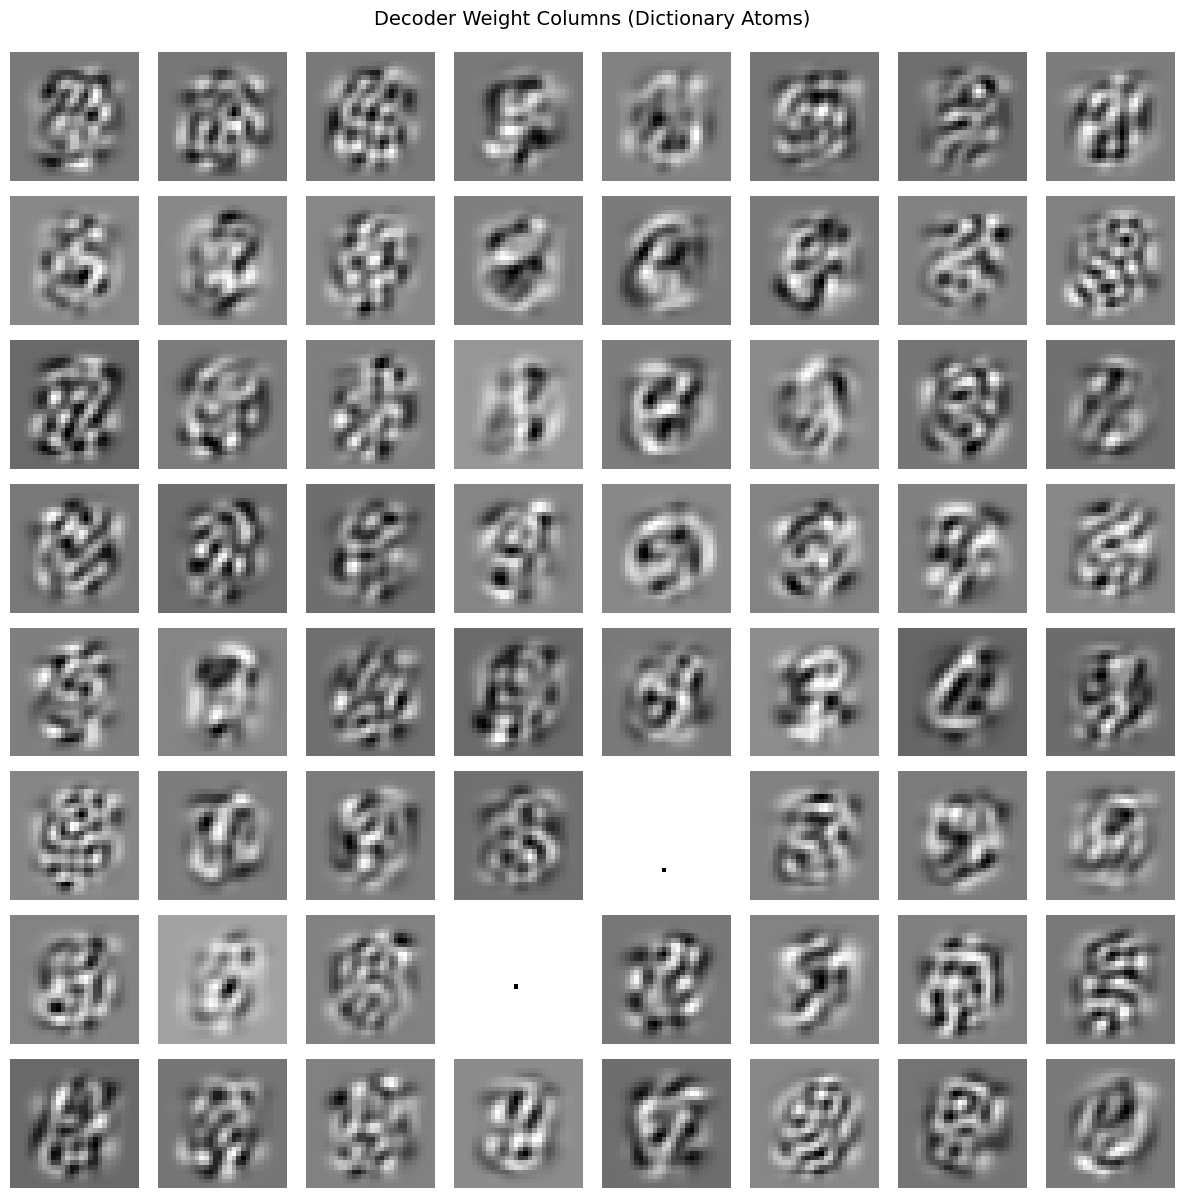


Encoder Features (what patterns activate each latent):


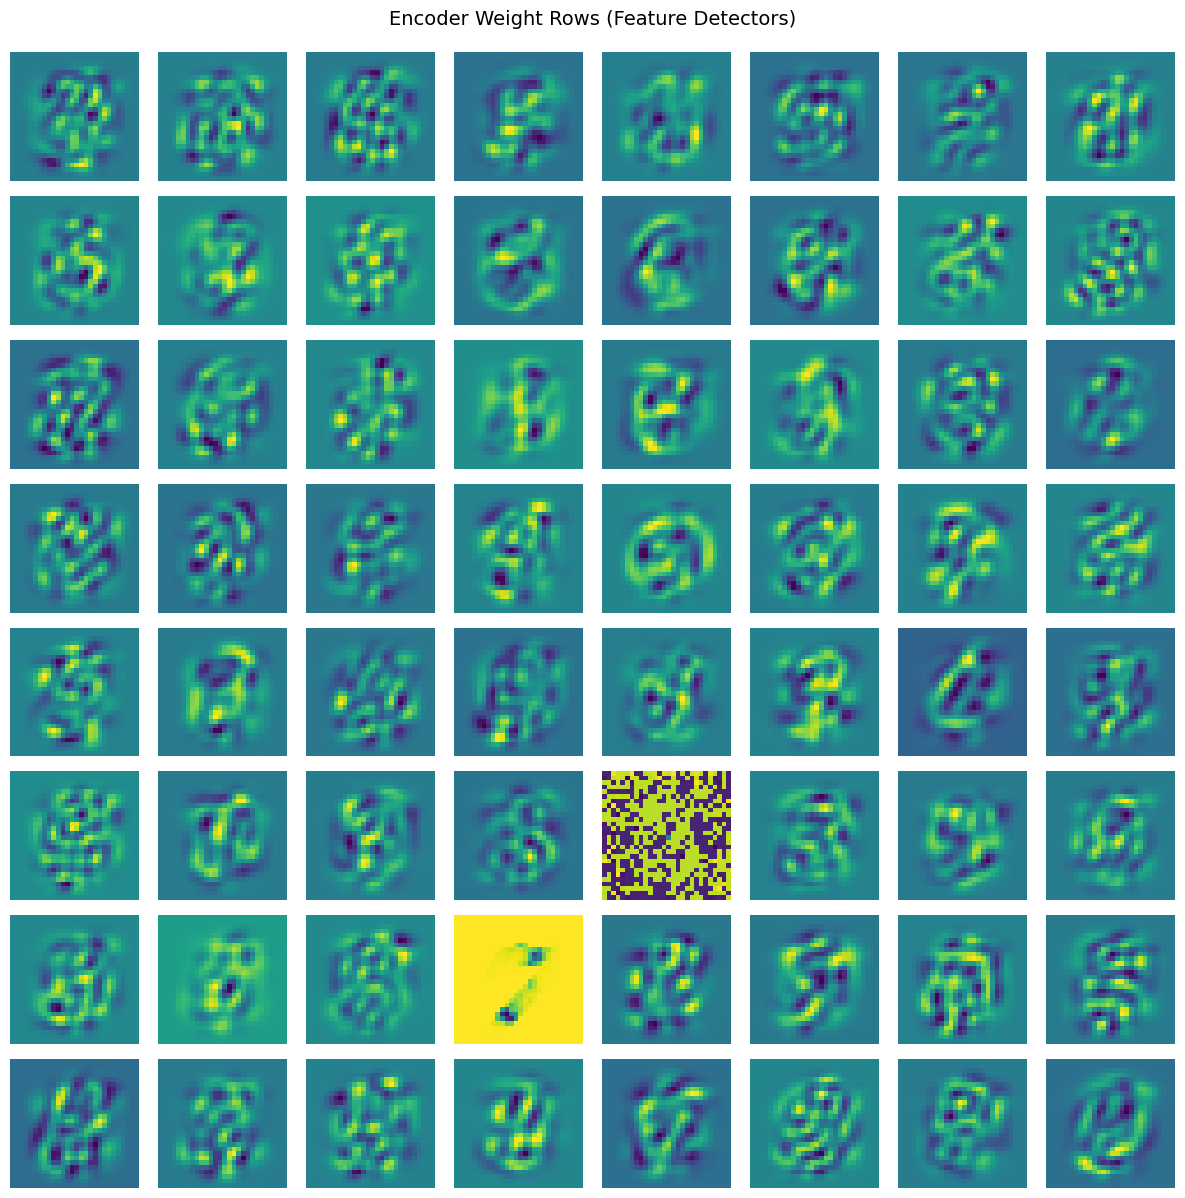


Reconstruction Comparison:


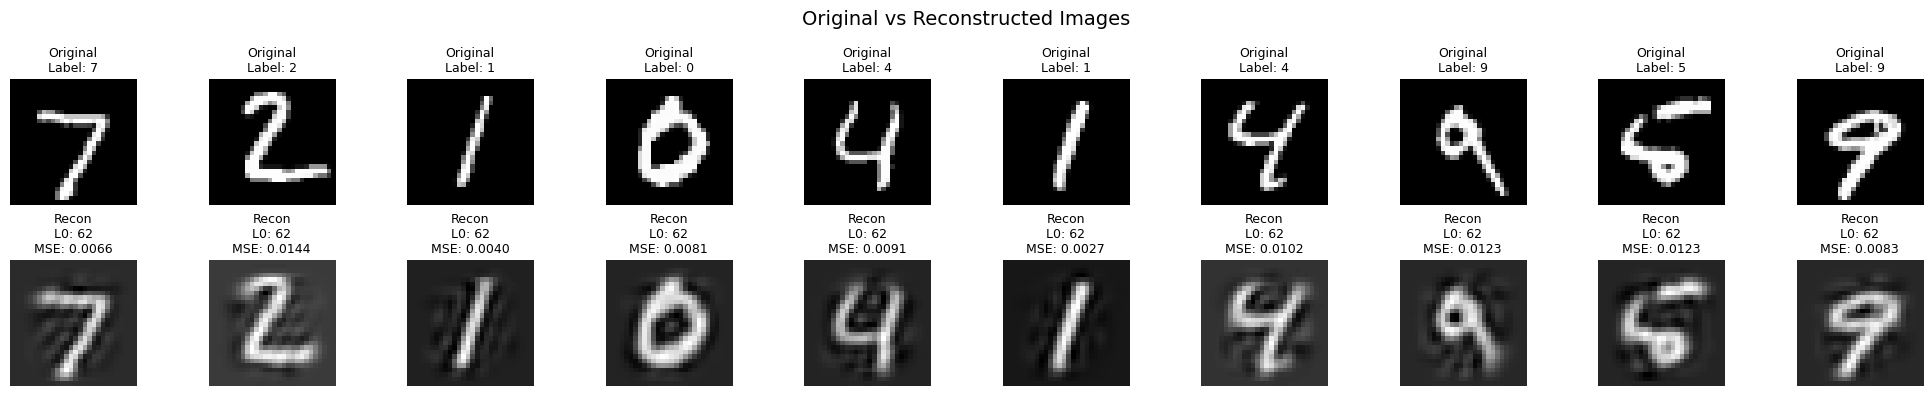


Activation Patterns for Sample Images:


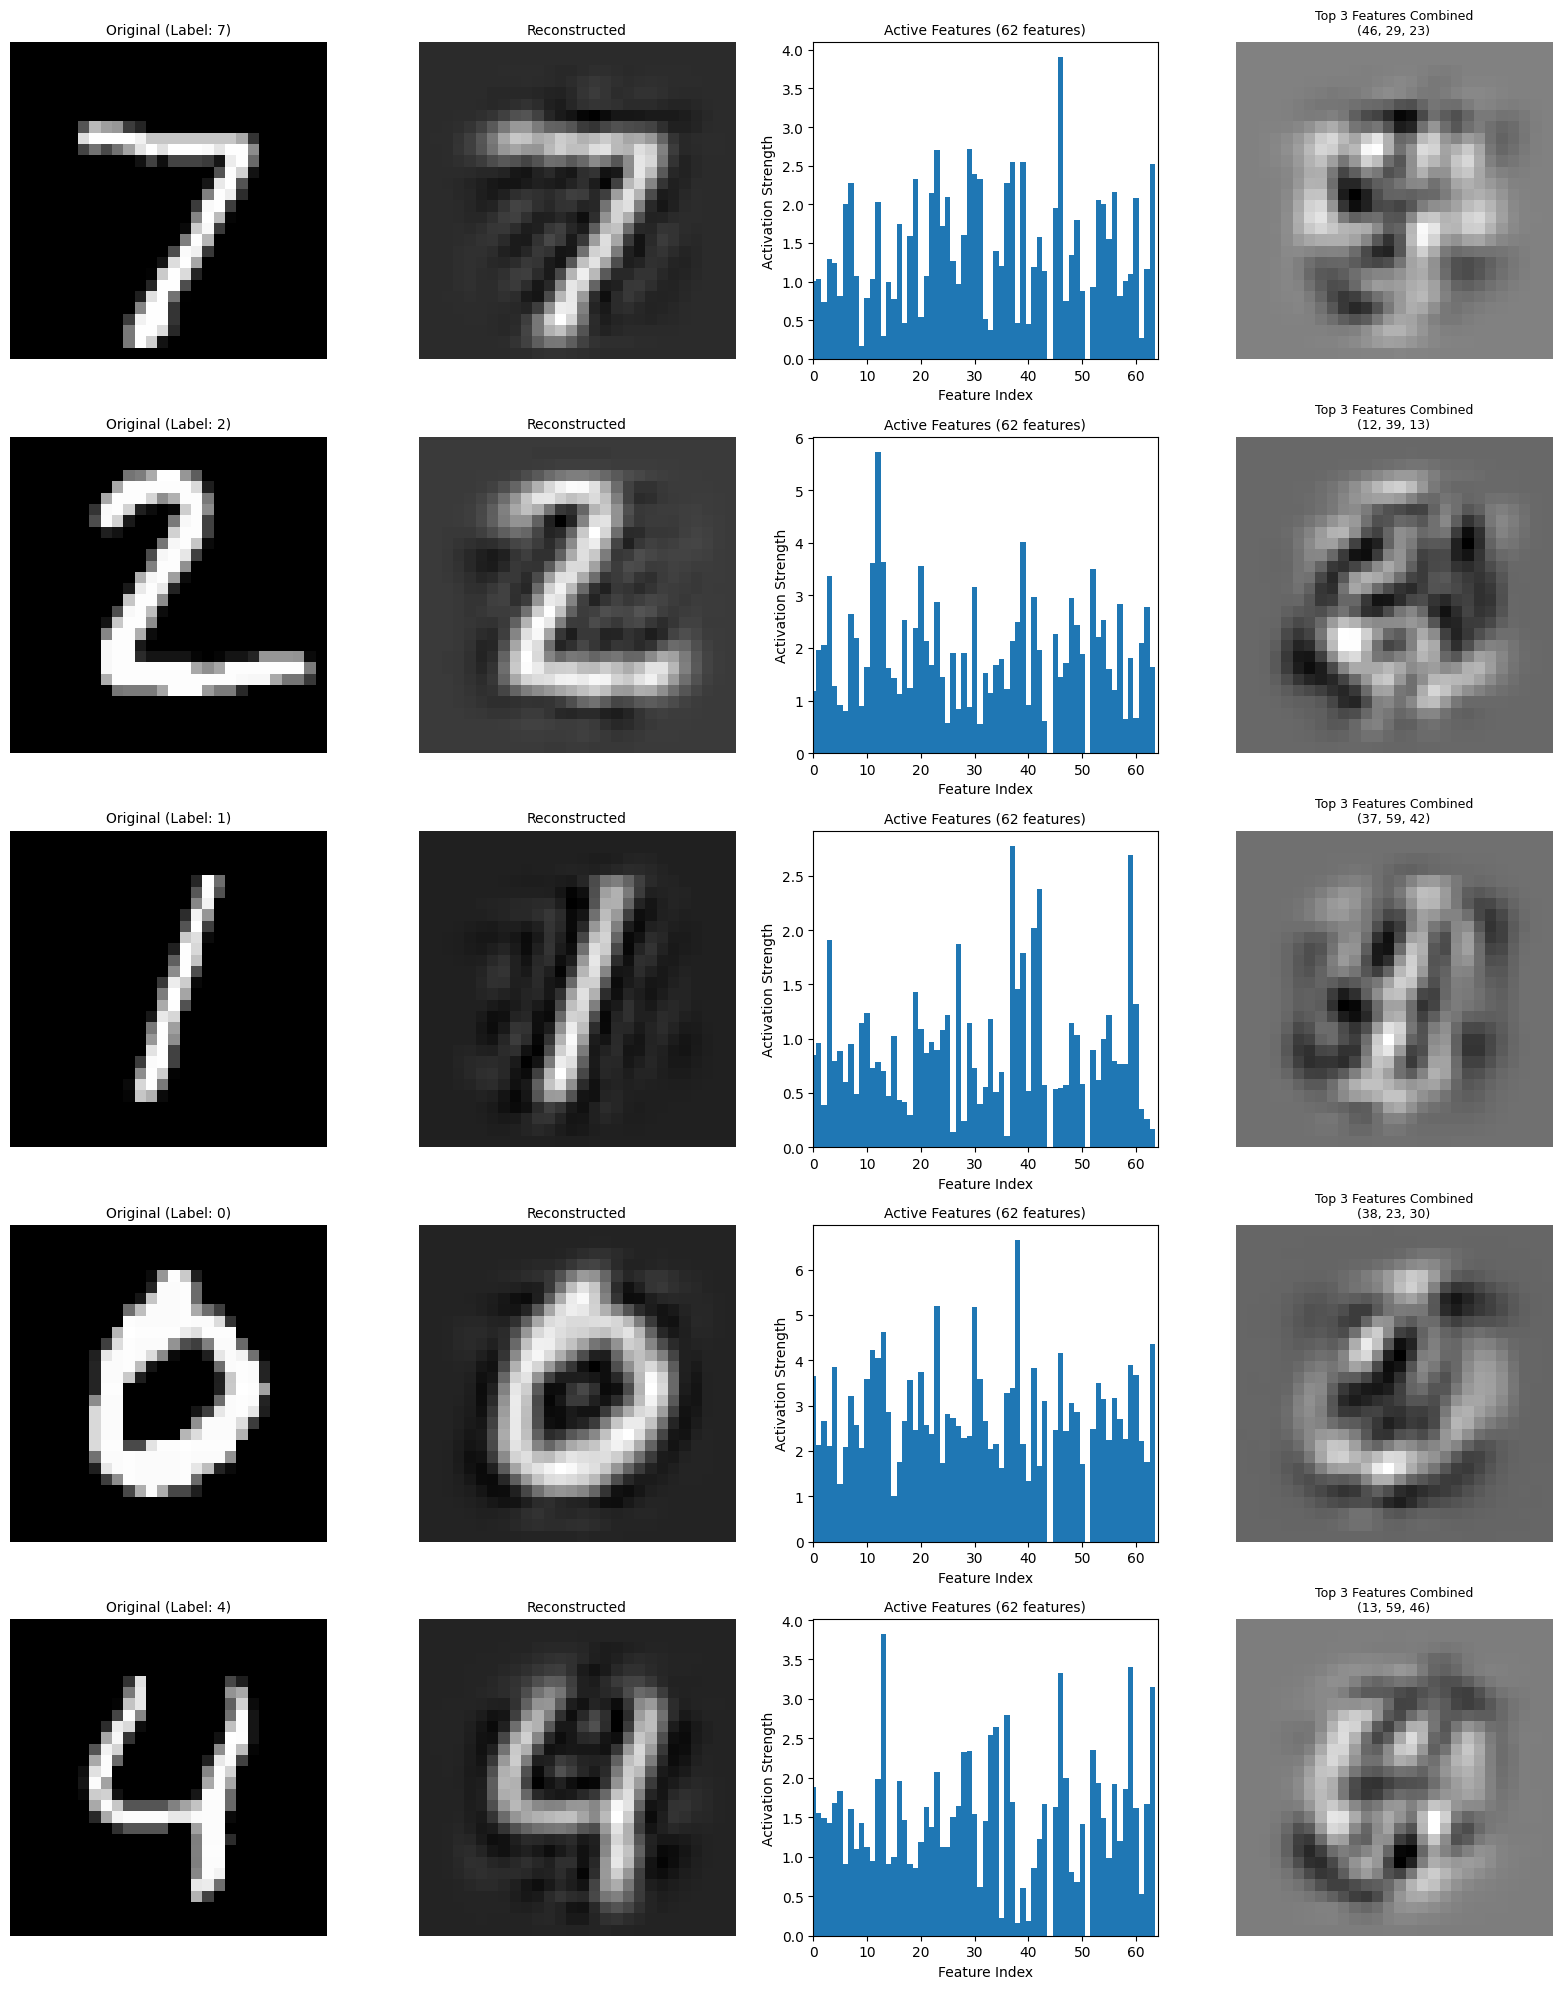


Encoder-Decoder Weight Comparison:


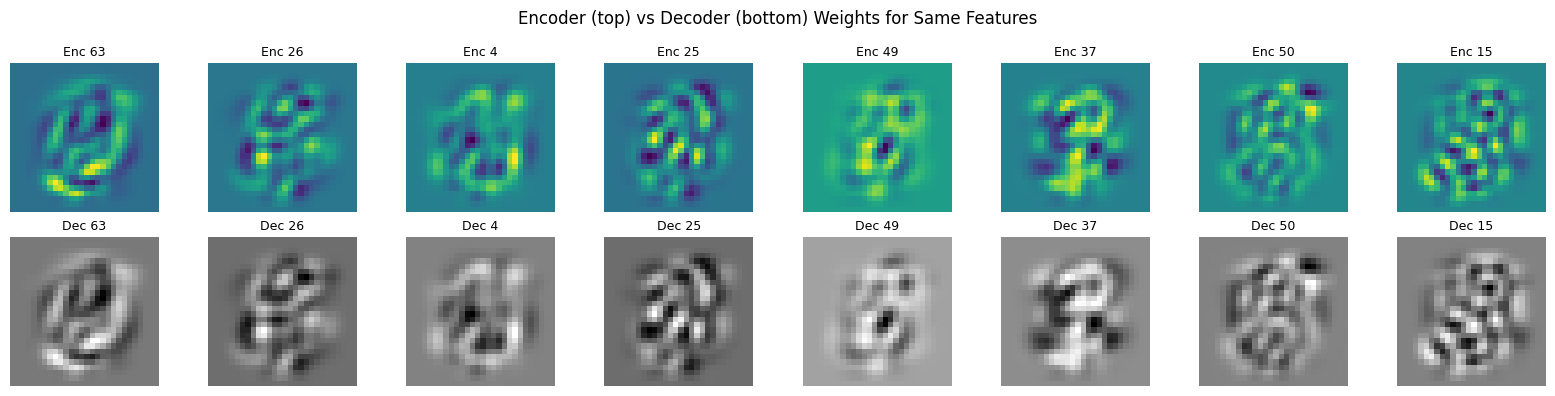

In [5]:

k_tests = [20, 64]
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

for k in k_tests:
    print(f"\nTraining with k={k}")
    model = train_topk_sparse_autoencoder(
        learning_rate=0.0005,
        num_epochs=50,
        batch_size=256,
        hidden_size=64,
        k_param=k,
        device=device
    )

    # Visualize all aspects
    visualize_decoder_features(model, hidden_size=64)
    visualize_encoder_features(model, hidden_size=64)
    visualize_reconstructions(model, testloader, device)
    visualize_activation_patterns(model, testloader, device)
    compare_encoder_decoder_relationship(model, n_display=8)




out of curiosity test

In [10]:
model = train_topk_sparse_autoencoder(
    learning_rate=0.0005,
    num_epochs=50,
    batch_size=256,
    hidden_size=15,
    k_param=10,
    device=device)

Computing MSE normalization constant...
MSE normalization constant: 0.095181

Training TopK Sparse Autoencoder
Hidden size: 15, K: 10, L0: 66.67%
------------------------------------------------------------
Epoch [5/50], Loss: 0.0309, Avg L0: 10.0, LR: 0.000488
Epoch [10/50], Loss: 0.0303, Avg L0: 10.0, LR: 0.000452
Epoch [15/50], Loss: 0.0301, Avg L0: 10.0, LR: 0.000397
Epoch [20/50], Loss: 0.0299, Avg L0: 10.0, LR: 0.000327
Epoch [25/50], Loss: 0.0298, Avg L0: 10.0, LR: 0.000250
Epoch [30/50], Loss: 0.0297, Avg L0: 10.0, LR: 0.000173
Epoch [35/50], Loss: 0.0297, Avg L0: 10.0, LR: 0.000103
Epoch [40/50], Loss: 0.0297, Avg L0: 10.0, LR: 0.000048
Epoch [45/50], Loss: 0.0297, Avg L0: 10.0, LR: 0.000012
Epoch [50/50], Loss: 0.0297, Avg L0: 10.0, LR: 0.000000
Finished training



Decoder Features (what each latent adds to reconstruction):


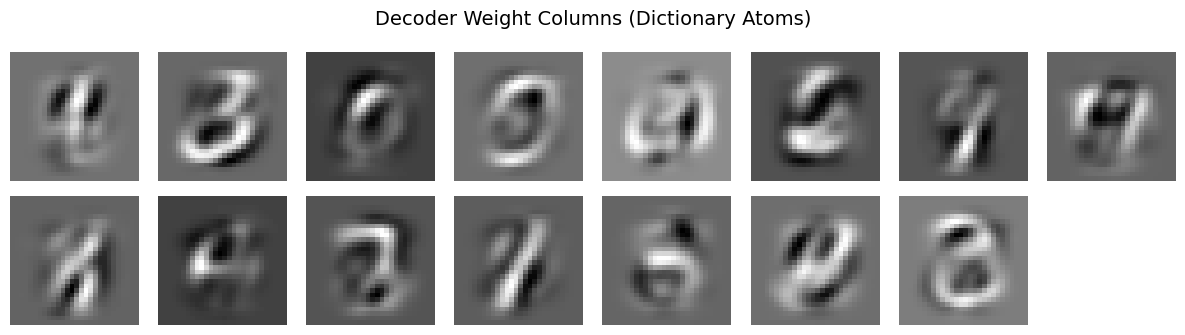


Encoder Features (what patterns activate each latent):


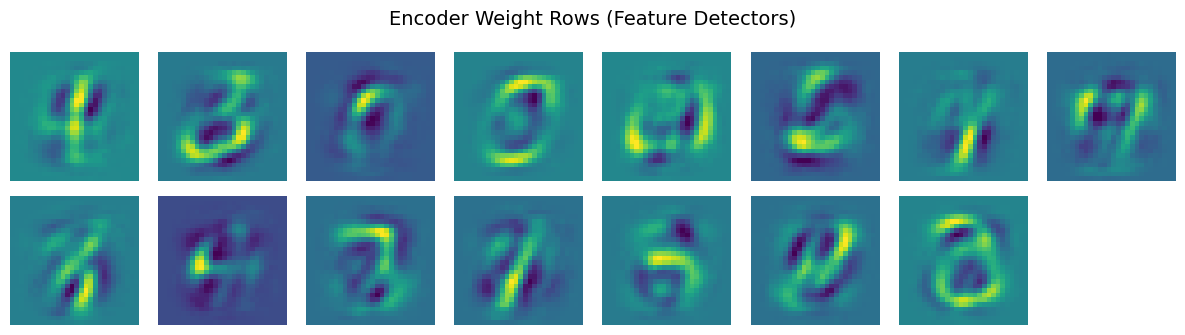


Reconstruction Comparison:


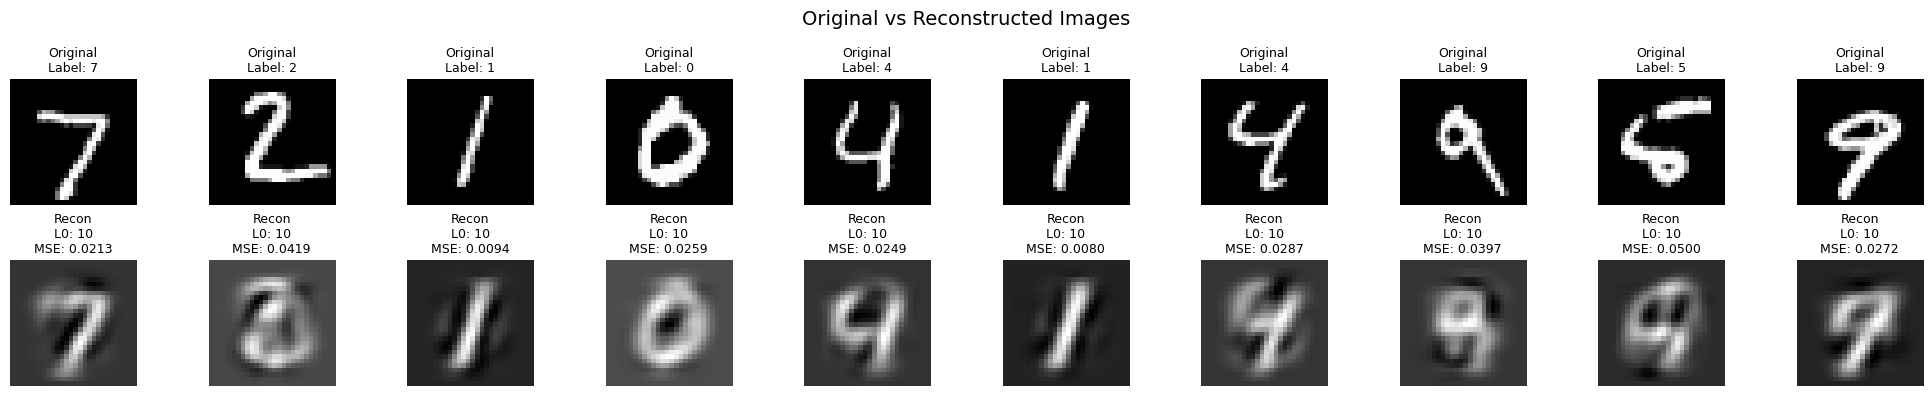


Activation Patterns for Sample Images:


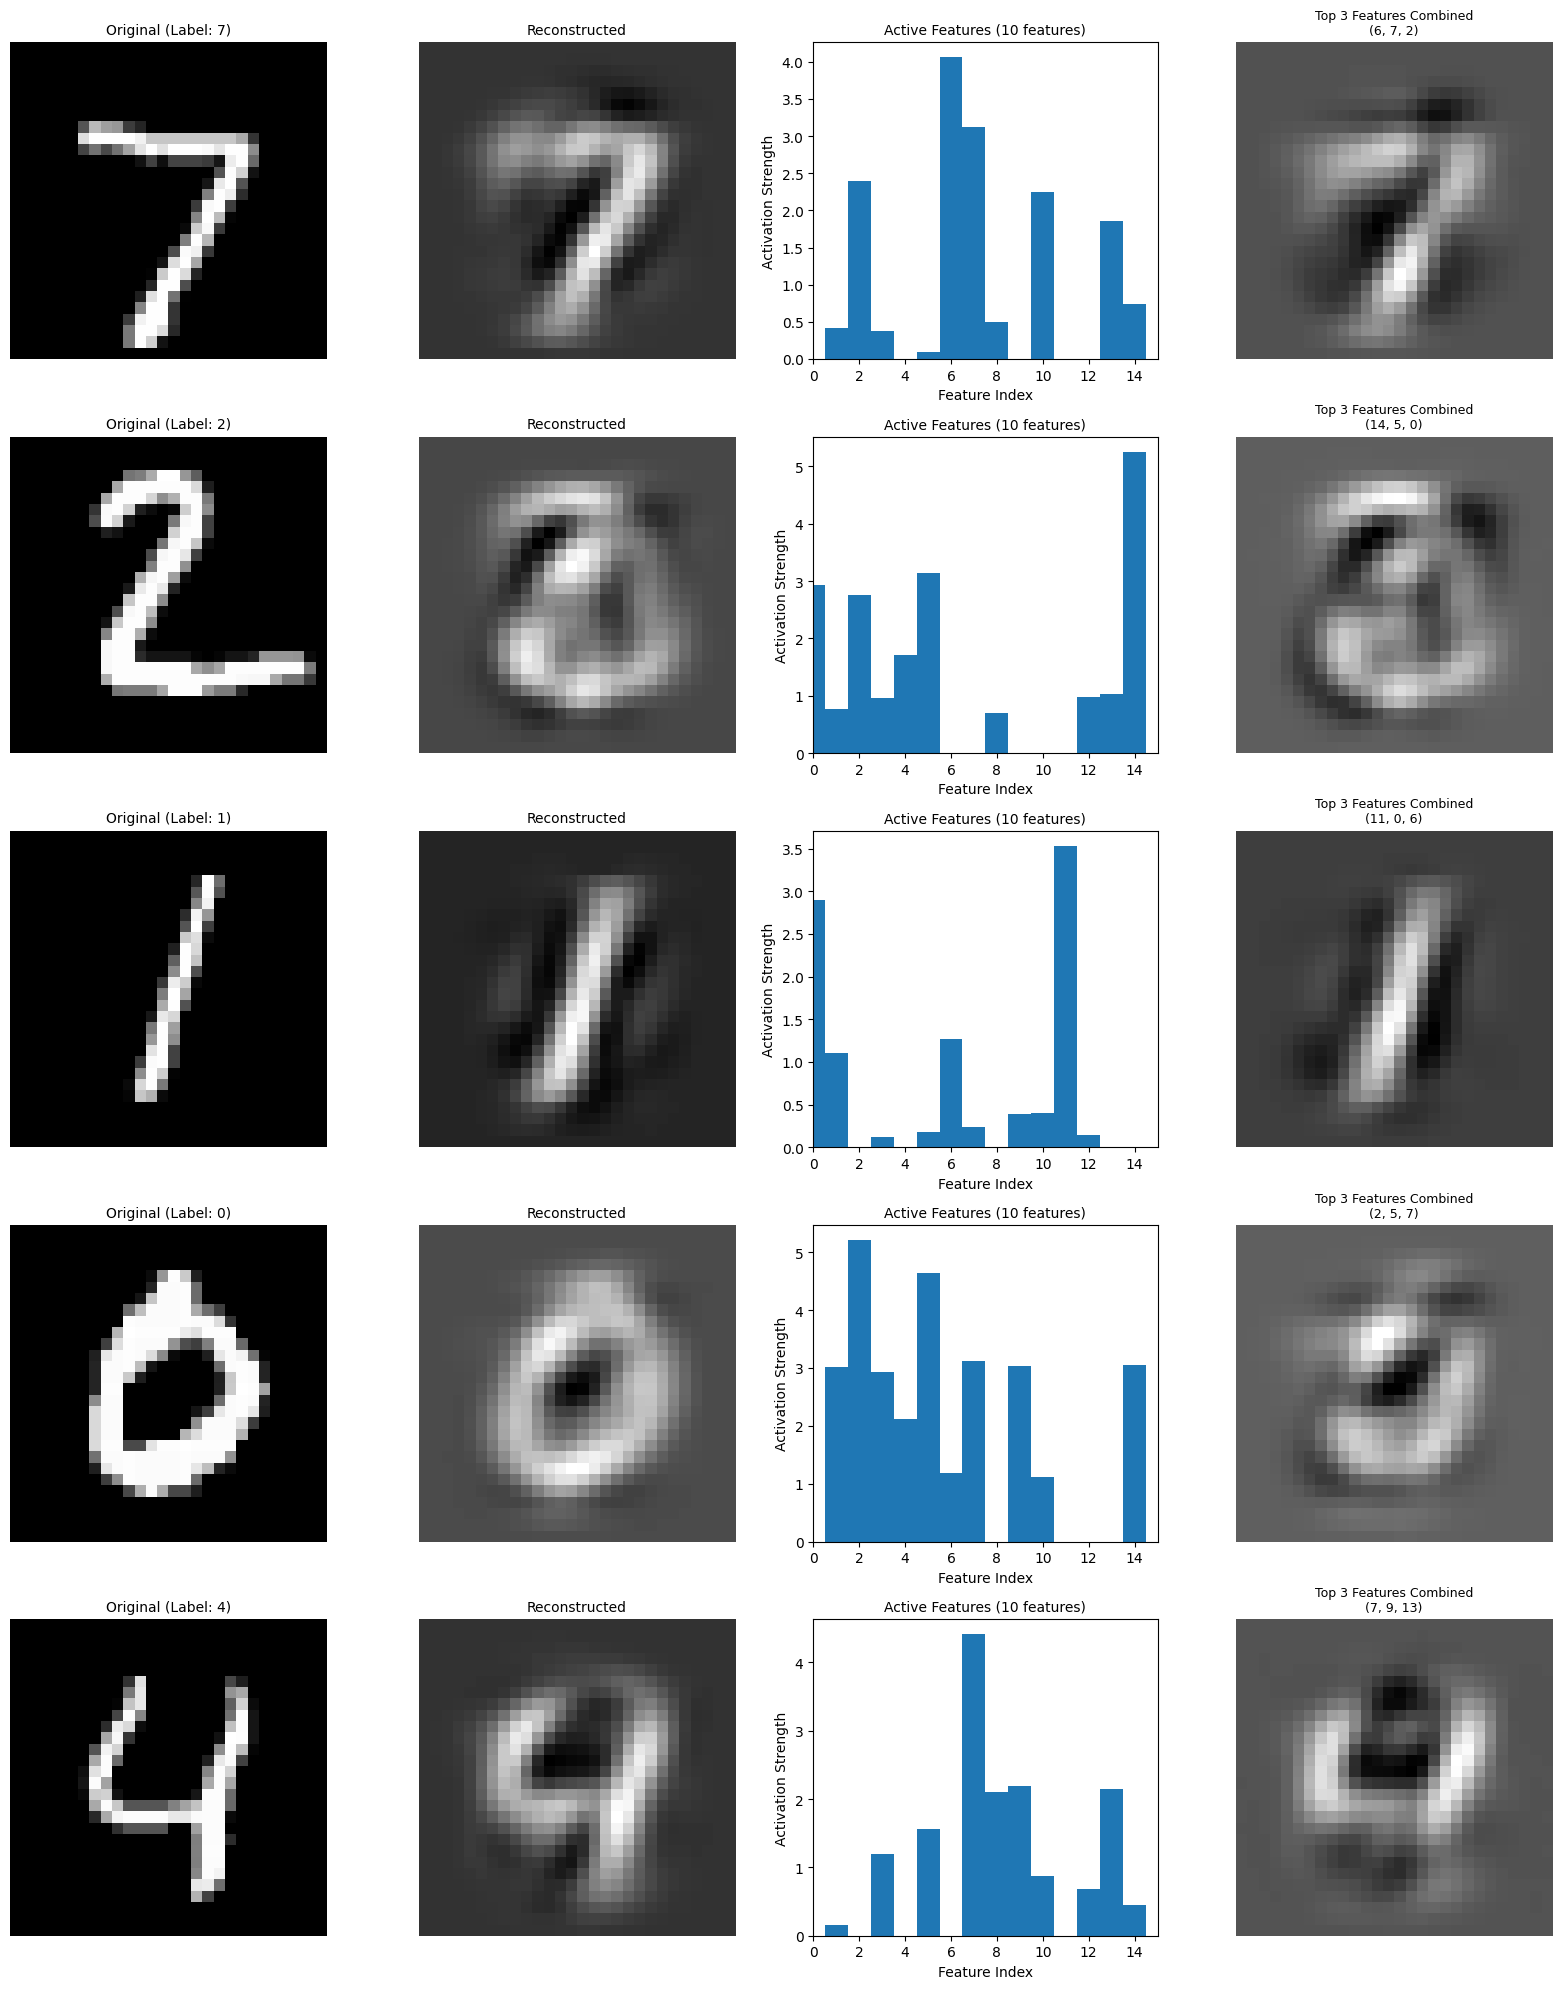


Encoder-Decoder Weight Comparison:


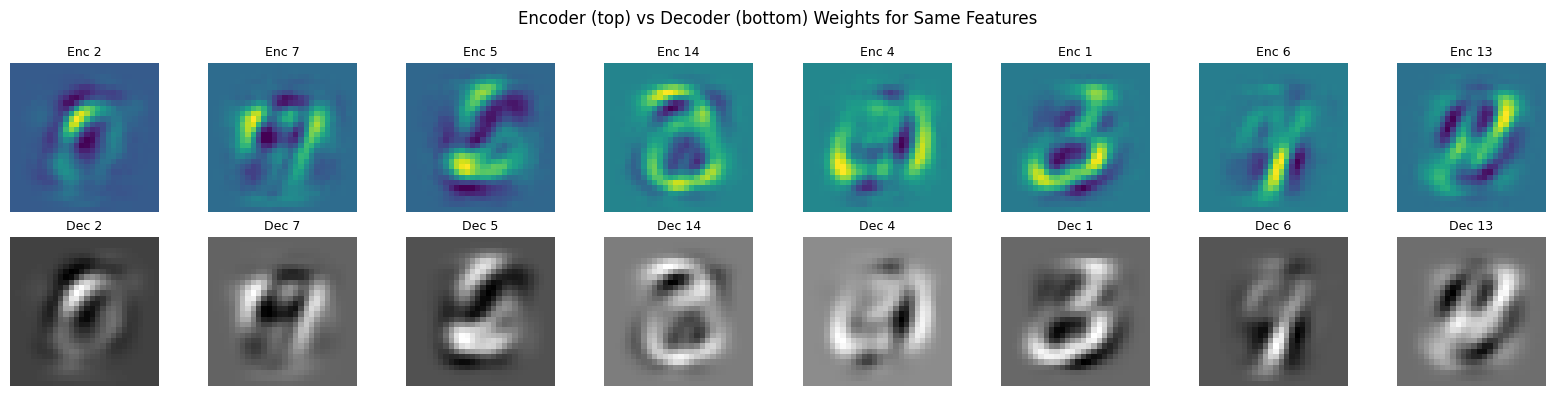

In [11]:
# Visualize all aspects
visualize_decoder_features(model, hidden_size=15)
visualize_encoder_features(model, hidden_size=15)
visualize_reconstructions(model, testloader, device)
visualize_activation_patterns(model, testloader, device)
compare_encoder_decoder_relationship(model, n_display=8)